## Setup, Loading Data and CDFs

In [1]:
DATA_NAME = 'ravdess-1e5rawre' #dataset-compression
TRANSFORM = 'erb-normal_intensity' #transform-group
CHANNEL = ''
NUM_BANDS = int(10)

In [2]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
normal_intensity_erb_1e5rawre_ravdess.ipynb


In [3]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results-audio", "case-studies", *path_list)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)

GROUP = 'band' 
RERUN = False
SKIP_OPTIMIZE_STEP = False
CWD

'e:\\Research\\UCB\\Strang Lab\\Github\\hierarchical-bayesian-model-validation\\results-audio\\case-studies\\ravdess\\1e5rawre\\erb\\normal_intensity'

In [4]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [5]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data-audio", "subsample-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data-audio", "subsample-data", f'{FULL_DATA_NAME}-size.pickle'))

In [6]:
if 'erb' in TRANSFORM:
    group_data_map.popitem()
NUM_BANDS = max(min(NUM_BANDS, len(group_data_map) - 2), 1)

In [7]:
#if 'fourier' in TRANSFORM:
#    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
#elif 'wavelet' in TRANSFORM:
#    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)
#GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::max(len(group_data_map) // NUM_BANDS, 1)]
GROUPS = np.linspace(2, sorted(group_data_map)[-1], NUM_BANDS, dtype=int)


cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
#group_total_samples
#group_data_map


Running 12760 CDFs


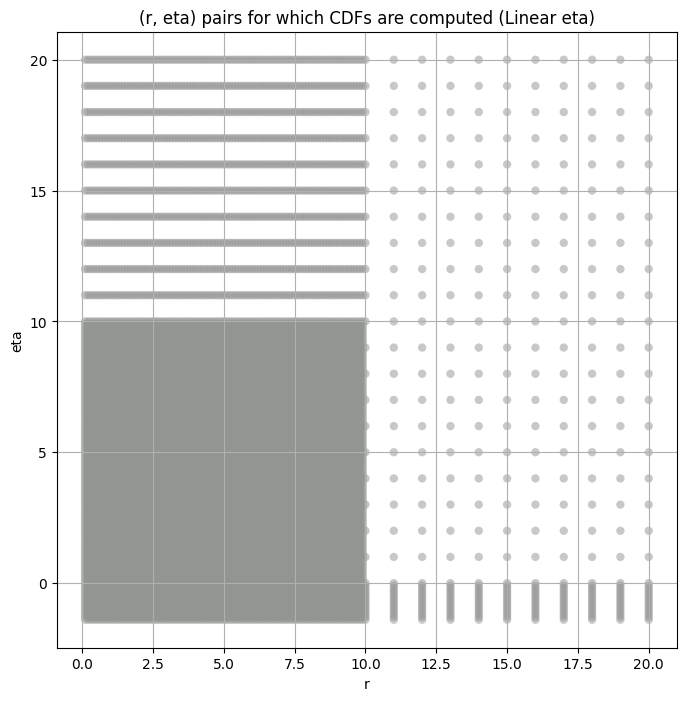

(r,eta),cdf    r  eta  \
0  ((0.1, -1.4), <scipy.interpolate._fitpack2.Int...  0.1 -1.4   
1  ((0.1, -1.3), <scipy.interpolate._fitpack2.Int...  0.1 -1.3   
2  ((0.1, -1.2), <scipy.interpolate._fitpack2.Int...  0.1 -1.2   
3  ((0.1, -1.1), <scipy.interpolate._fitpack2.Int...  0.1 -1.1   
4  ((0.1, -1.0), <scipy.interpolate._fitpack2.Int...  0.1 -1.0   

                                                 cdf      variance  \
0  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.628800e+06   
1  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.991680e+07   
2  <scipy.interpolate._fitpack2.InterpolatedUniva...  2.395008e+08   
3  <scipy.interpolate._fitpack2.InterpolatedUniva...  1.037837e+09   
4  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.632429e+09   

        kurtosis  
0  554265.000000  
1   96192.272727  
2   29390.000000  
3   11997.692308  
4    5874.890110

In [8]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [9]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [10]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Band 2


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 3


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 5


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 6


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 8


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 9


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 11


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 12


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 14


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 16


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

obs_var  var_lower  var_upper    obs_kurt  kurt_lower  kurt_upper  \
band                                                                       
2     0.019185   0.015339   0.024193   77.111083   32.462231  143.300153   
3     0.290274   0.250924   0.333447   28.419666   22.643105   35.219307   
5     2.376846   2.199406   2.559823    6.729836    5.871219    7.655770   
6     1.501561   1.384670   1.622058    7.474615    6.587994    8.426250   
8     0.123590   0.108467   0.141458   24.692726   14.516626   44.993672   
9     0.030323   0.026899   0.034846   22.783432   10.848627   68.245280   
11    0.017838   0.014691   0.021523   52.056832   33.944059   89.044404   
12    0.007811   0.006184   0.009895   81.076527   46.481374  165.296812   
14    0.000473   0.000361   0.000701  175.249809   47.627103  614.202212   
16    0.000118   0.000077   0.000184  299.694420  109.983114  753.488633   

      total_samples  
band                 
2           98856.0  
3          110055.0  
5         1090100.0  
6          550640.0  
8         3568842.0  
9         5354720.0  
11        6785573.0  
12       22346151.0  
14       12581431.0  
16        8227229.0

## Initial Grid Search and Hypothesis Test Plots

In [11]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [12]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

obs_var  var_exclude_0  var_exclude_25  var_exclude_50  var_exclude_75  \
band                                                                            
2     0.019185       0.019185        0.016268        0.014949        0.014083   
3     0.290274       0.290274        0.272768        0.260532        0.250197   
5     2.376846       2.376846        2.328898        2.289861        2.254891   
6     1.501561       1.501561        1.470853        1.445545        1.422731   
8     0.123590       0.123590        0.114800        0.110035        0.106323   
9     0.030323       0.030323        0.028316        0.027350        0.026604   
11    0.017838       0.017838        0.016028        0.014986        0.014171   
12    0.007811       0.007811        0.006760        0.006207        0.005785   
14    0.000473       0.000473        0.000395        0.000362        0.000337   
16    0.000118       0.000118        0.000085        0.000072        0.000063   

      var_exclude_100  var_exclude_150  var_exclude_200  var_exclude_250  \
band                                                                       
2            0.013397         0.012377         0.011628         0.011036   
3            0.241244         0.225769         0.212536         0.201046   
5            2.222557         2.164084         2.111536         2.063422   
6            1.401573         1.363271         1.328672         1.296757   
8            0.103200         0.098063         0.093891         0.090343   
9            0.025980         0.024944         0.024084         0.023336   
11           0.013488         0.012372         0.011467         0.010705   
12           0.005439         0.004885         0.004449         0.004091   
14           0.000316         0.000283         0.000258         0.000236   
16           0.000056         0.000046         0.000039         0.000034   

      var_exclude_300  var_exclude_350  var_exclude_500  
band                                                     
2            0.010549         0.010137         0.009190  
3            0.190981         0.182117         0.160279  
5            2.018668         1.976814         1.864641  
6            1.267090         1.239125         1.163906  
8            0.087246         0.084493         0.077674  
9            0.022668         0.022062         0.020514  
11           0.010047         0.009468         0.008075  
12           0.003787         0.003525         0.002910  
14           0.000218         0.000203         0.000167  
16           0.000029         0.000026         0.000019

####
Band  2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 0 0.007151436775900133 0.0191850473674253


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 25 0.0038022470896165173 0.016267528681863683


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 50 0.0023446002966035495 0.01494929279094437


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 75 0.002768912974661919 0.014082600979036028


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 100 0.0026678774311722497 0.013397189314831316


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 150 0.00326179950214045 0.012377077986258308


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 200 0.0035829862517182676 0.01162829773829895


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 250 0.0037364102309393205 0.011036428763196656


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 300 0.004484242871144722 0.01054909990013705


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 350 0.005084964509790105 0.010137365463288358


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 500 0.007042122705514096 0.009189712502568769
Number of samples: 100000, Without approximation : 98856.0


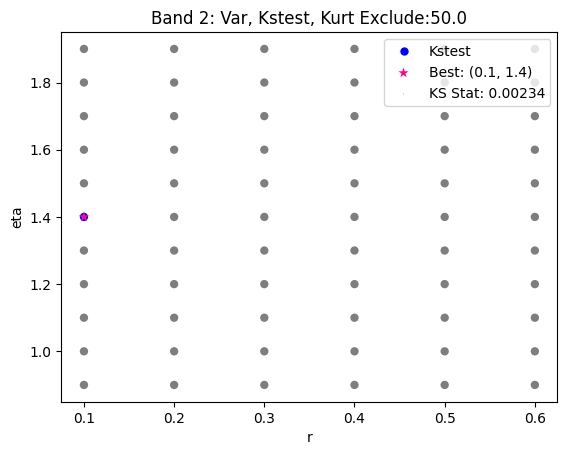

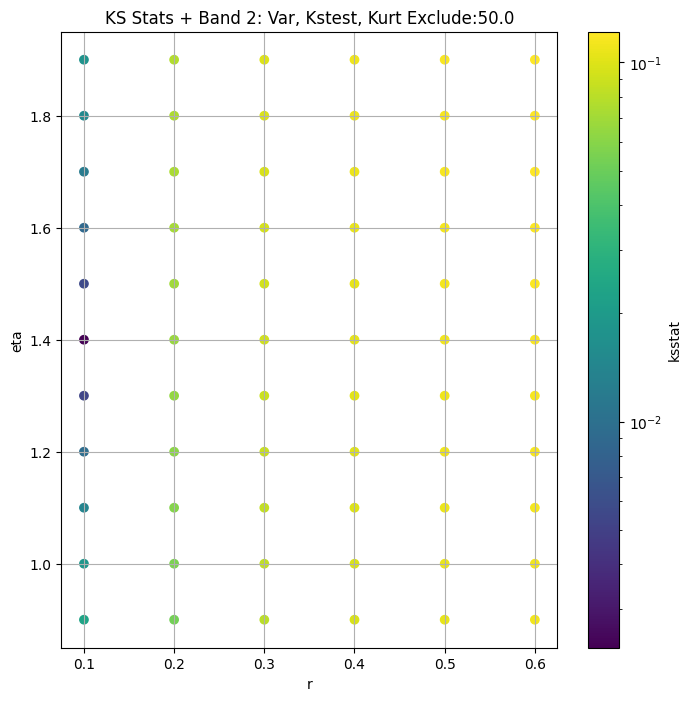

####
Band  3


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 0 0.021028503132165643 0.2902739898785912


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 25 0.017759897946182823 0.2727679772857708


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 50 0.01744860856471942 0.26053247996807266


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 75 0.0182701423906897 0.2501969515484272


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 100 0.019053268922053036 0.2412435819659689


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 150 0.020839097397364392 0.22576904094334196


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 200 0.019516164386227386 0.2125358617042327


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 250 0.02039016393207934 0.2010456657317875


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 300 0.02148114598296249 0.19098121201301732


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 350 0.022468241115823143 0.1821166678338764


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 500 0.023120590299855824 0.16027873746309623
Number of samples: 100000, Without approximation : 110055.0


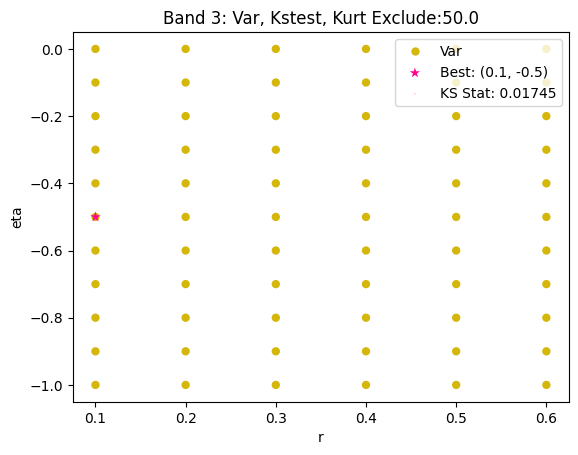

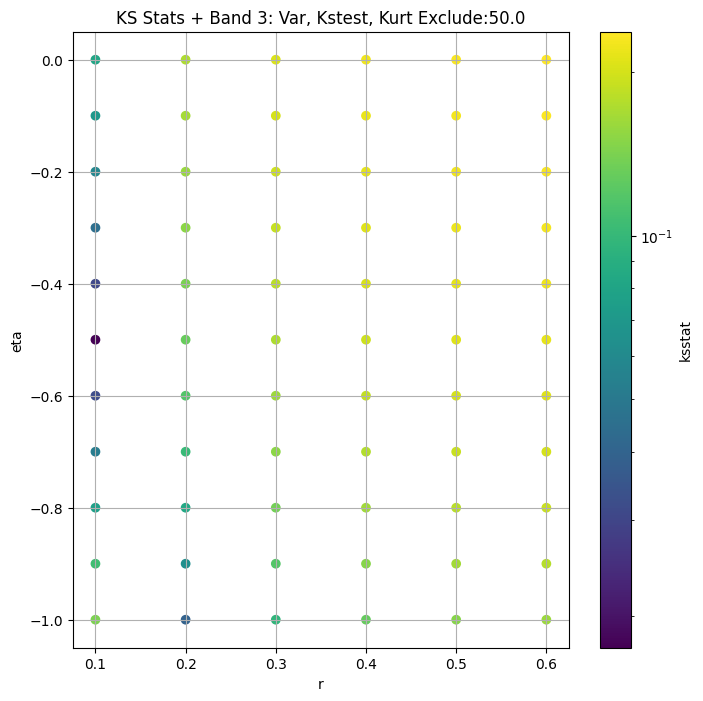

####
Band  5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 0 0.012682760622671374 2.3768459671231406


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 25 0.011731719366842697 2.328898151629391


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 50 0.010939937976159997 2.2898607129401913


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 75 0.010825484925615317 2.254890811283526


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 100 0.011561534373635399 2.2225574328755946


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 150 0.012802352228418357 2.164083619157868


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 200 0.012566719644635682 2.111535604423584


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 250 0.01265421193785754 2.063422339915395


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 300 0.012646622680171304 2.018668428771816


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 350 0.012522530206565408 1.9768143533639833


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 500 0.012383453614537632 1.8646411437651893
Number of samples: 100000, Without approximation : 1090100.0


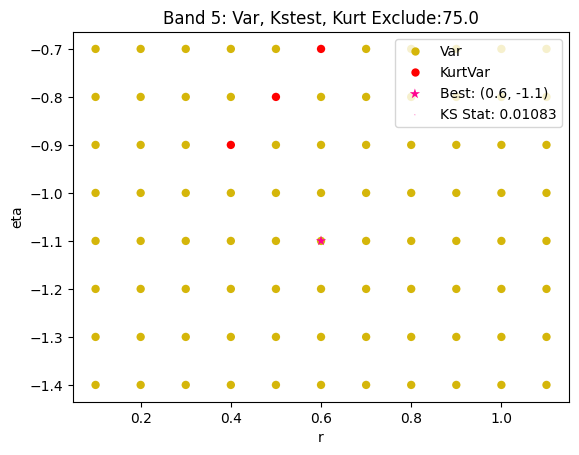

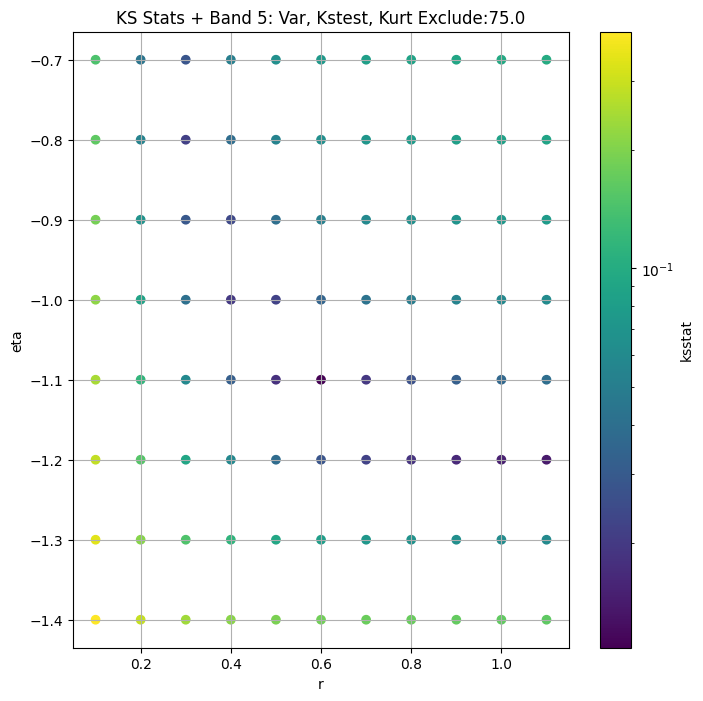

####
Band  6


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 0 0.012479044945319373 1.501561330909322


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 25 0.011404714754773337 1.4708530837717586


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 50 0.01083370739471616 1.4455452824350015


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 75 0.011439801412074131 1.4227312259560239


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 100 0.012036227479700429 1.4015731168151573


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 150 0.013185945855480566 1.3632708927510633


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 200 0.013972874686922043 1.3286715902073436


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 250 0.014357876336592301 1.296757213897834


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 300 0.014282795772756596 1.267090172940694


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 350 0.013416405354365224 1.2391246037038932


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 500 0.013226263541177175 1.163906372395138
Number of samples: 100000, Without approximation : 550640.0


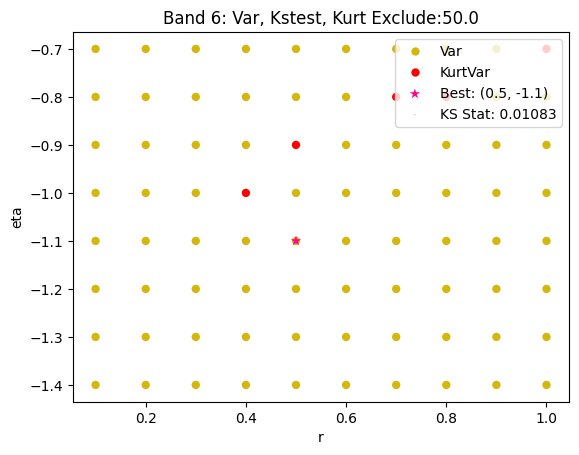

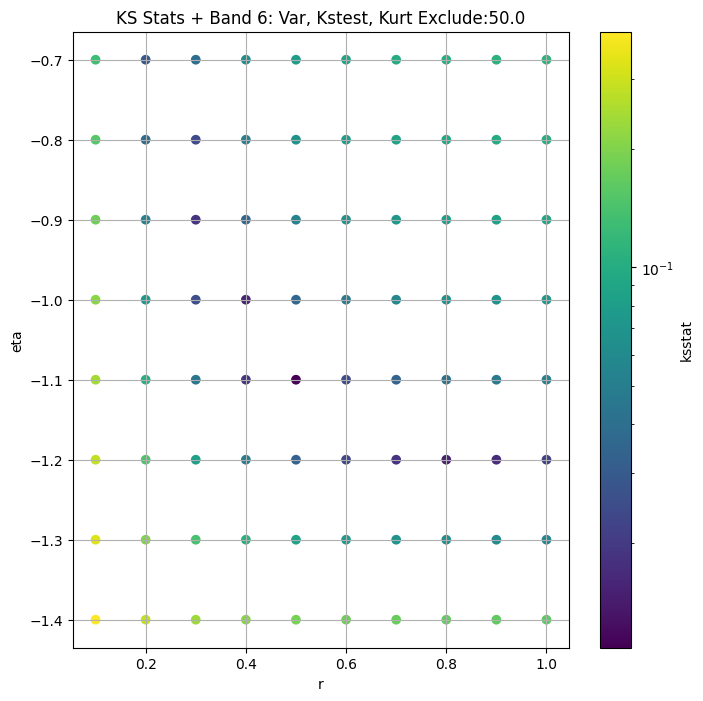

####
Band  8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 0 0.0025114112801521427 0.12358964145251065


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 25 0.004679328214776957 0.11480020167258212


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 50 0.006665509493010369 0.1100352041765001


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 75 0.006874495028176997 0.1063232424325467


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 100 0.007458027806121537 0.10319957829681374


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 150 0.007735802109359091 0.09806344491190079


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 200 0.005595863702634096 0.09389144831445906


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 250 0.005609364344972001 0.09034347661950584


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 300 0.006138549745793864 0.08724623362585436


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 350 0.0068492548433225775 0.08449330430363072


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 500 0.00870104435691546 0.07767352330510659
Number of samples: 100000, Without approximation : 3568842.0


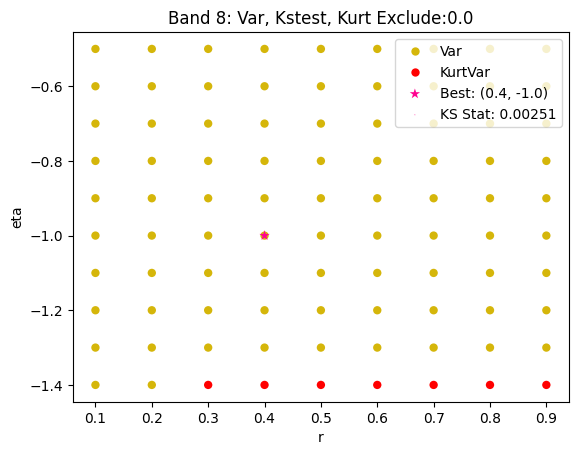

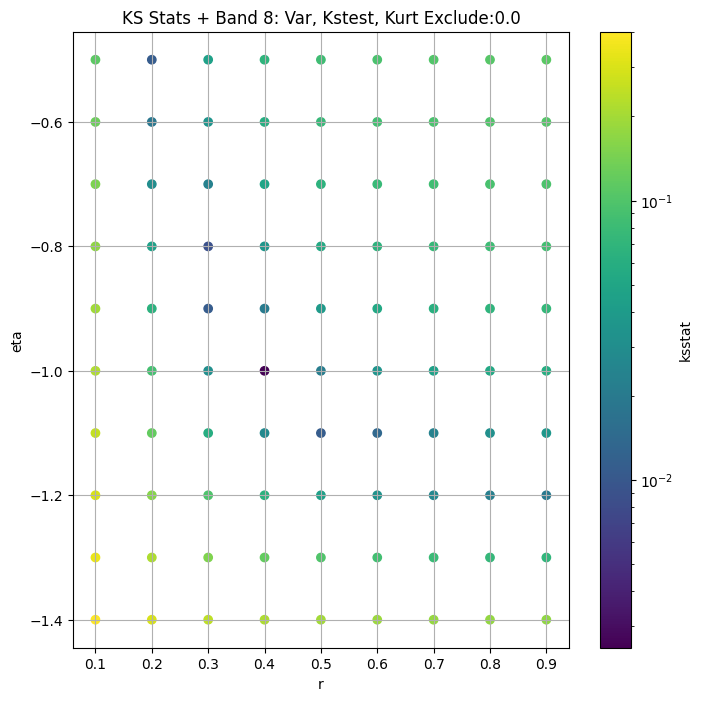

####
Band  9


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 0 0.00542643502855189 0.03032291937007524


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 25 0.006136280370972247 0.02831566071149924


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 50 0.0065689034488969344 0.027350050295943566


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 75 0.006941015153388019 0.02660430478161393


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 100 0.007282200344133627 0.025979673804696842


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 150 0.006431557020641465 0.024944265736752368


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 200 0.005211929687820693 0.02408428325853579


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 250 0.006303683968489265 0.023335666863201234


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 300 0.007456727682025974 0.0226679658661276


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 350 0.007219231318937799 0.022062476358226616


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 500 0.009134849161800913 0.020514387882983626
Number of samples: 100000, Without approximation : 5354720.0


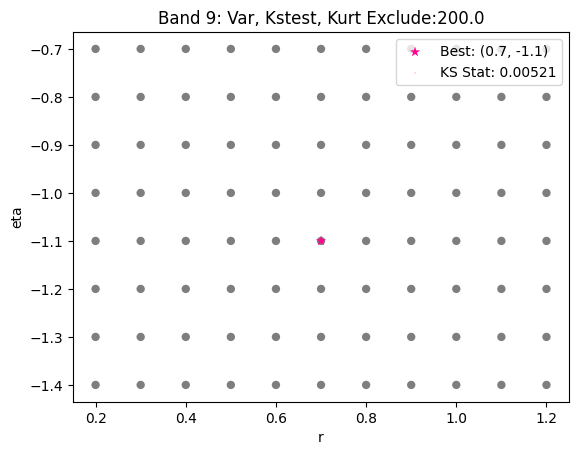

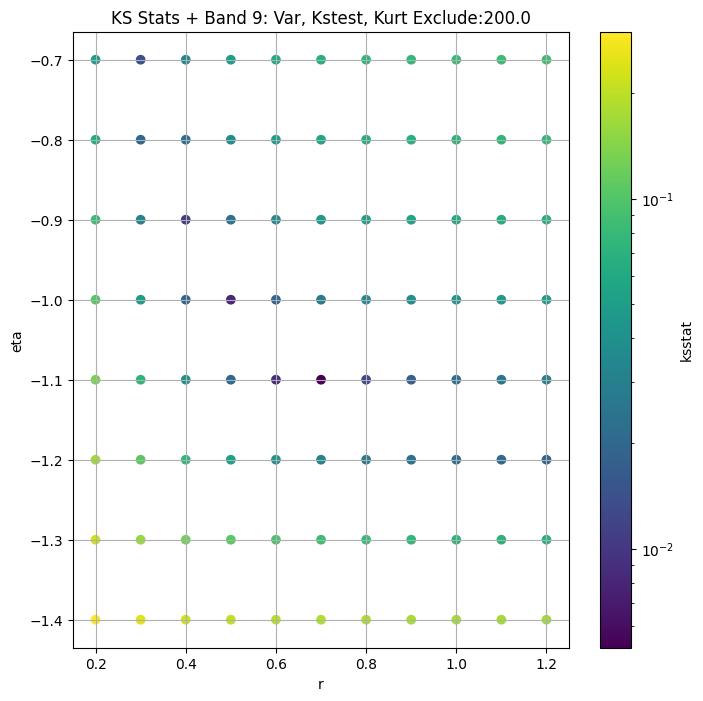

####
Band  11


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 0 0.012830030692699113 0.017838169067403986


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 25 0.0073331707407181534 0.016028315489212953


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 50 0.007810088240599637 0.014986254974617187


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 75 0.00901427354206704 0.014171005371837889


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 100 0.010160769568452029 0.013488482389302567


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 150 0.009799822434343172 0.012372064903438212


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 200 0.011494093234073396 0.011467010072769894


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 250 0.013189868053196122 0.01070533789162924


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 300 0.012546410447778975 0.010047219133720834


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 350 0.011503645100919724 0.009468097441550158


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 500 0.012708484185663733 0.008075379395438701
Number of samples: 100000, Without approximation : 6785573.0


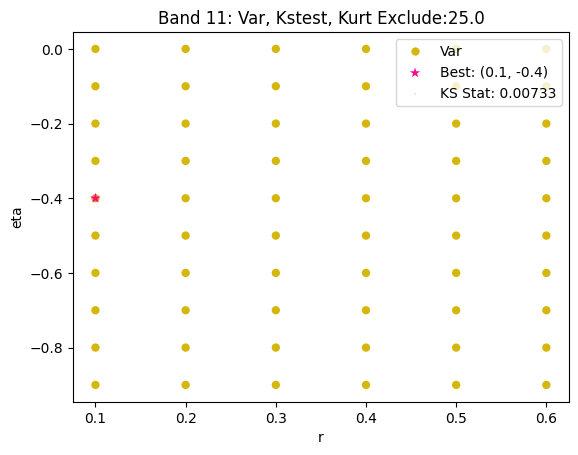

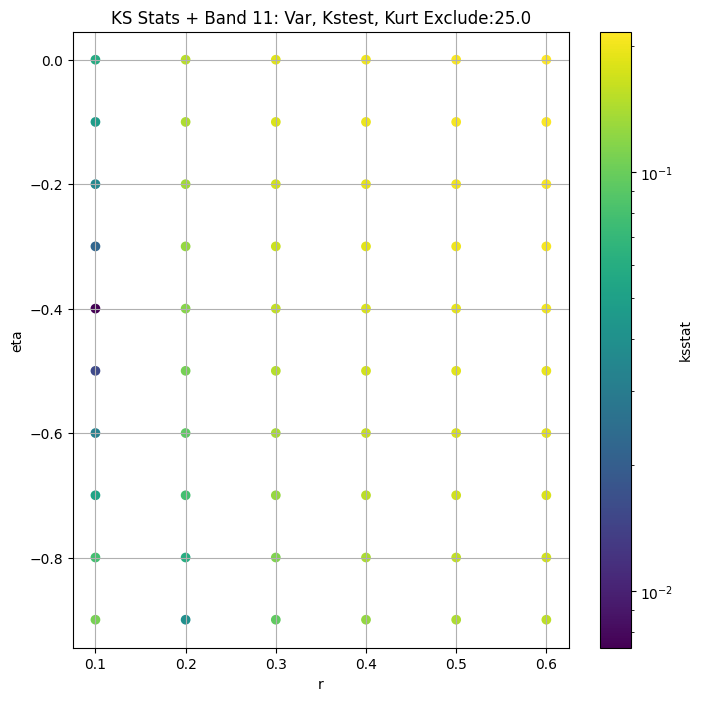

####
Band  12


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
12 0 0.02071903050651569 0.007810768759589744


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
12 25 0.013411903570667905 0.006760485791928704


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
12 50 0.014908633831472673 0.006207255743044515


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
12 75 0.01687589878901291 0.005785335752008048


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
12 100 0.01522723506159085 0.005438532334244256


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
12 150 0.009543810413586873 0.00488519591077759


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
12 200 0.011895815895174577 0.004449448159624415


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
12 250 0.01239446555843915 0.004090743252842689


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
12 300 0.009597284678529754 0.0037870195307879734


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
12 350 0.010636108102145107 0.0035247896132782485


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
12 500 0.012605011156904888 0.0029103431484465516
Number of samples: 100000, Without approximation : 22346151.0


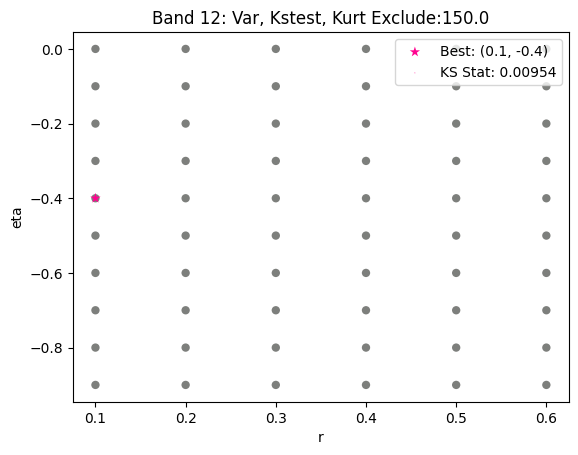

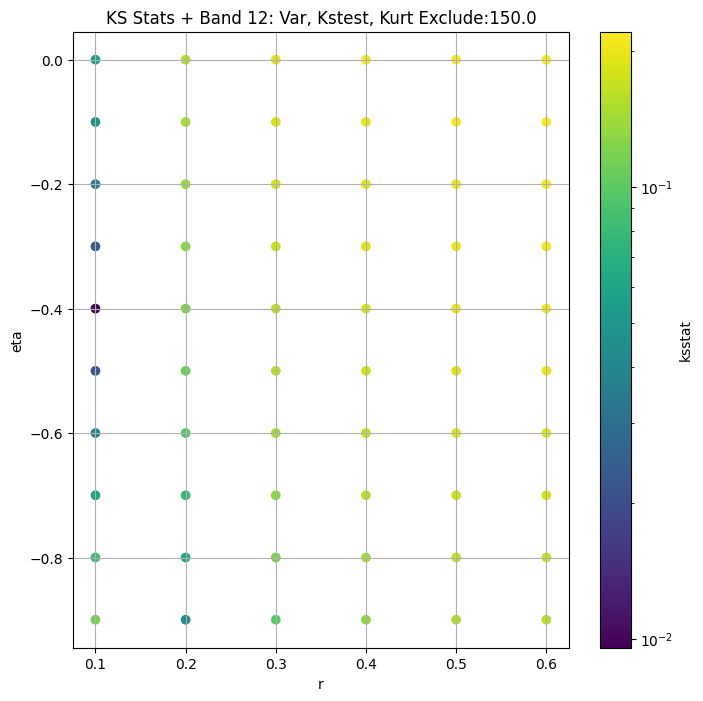

####
Band  14


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 0 0.0268353163898718 0.0004732935650215869


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 25 0.022774696844666376 0.00039463705210680437


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 50 0.023492559022414428 0.00036168952387010176


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 75 0.019693525881227747 0.0003367352499933815


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 100 0.01807224709496036 0.0003162426116460783


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 150 0.020049461618849906 0.00028349207670955547


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 200 0.014794325967717459 0.00025768836795831367


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 250 0.017528065904779067 0.00023643910589372718


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 300 0.01435757817594041 0.00021846958704533048


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 350 0.013133096621766427 0.00020299426242637088


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 500 0.011501766941031943 0.00016689944376377863
Number of samples: 100000, Without approximation : 12581431.0


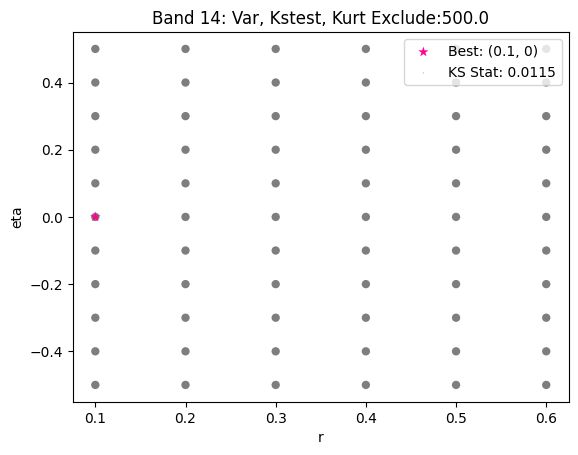

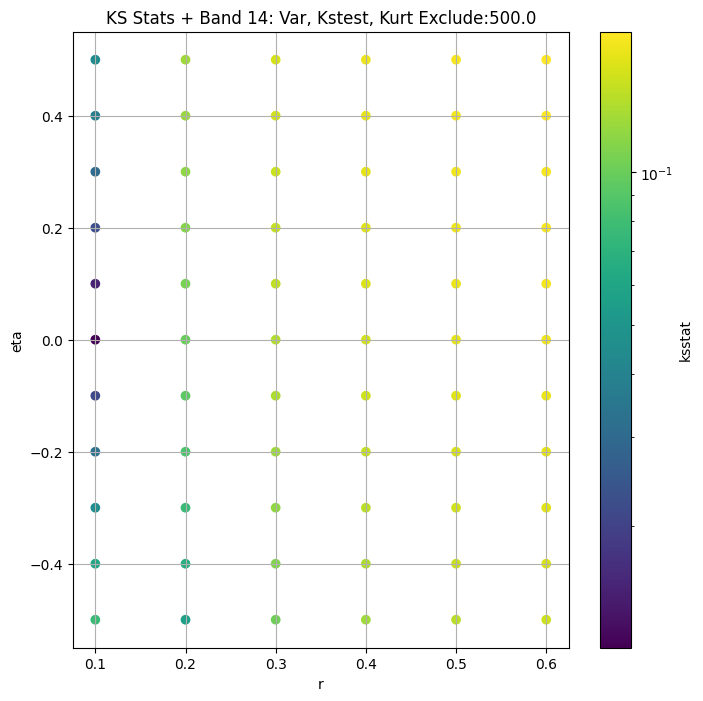

####
Band  16


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
16 0 0.03824752468847681 0.00011756863112139853


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
16 25 0.037988987389362405 8.506235109704287e-05


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
16 50 0.033639898009935665 7.197364700418532e-05


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
16 75 0.03661971919381235 6.297326813147742e-05


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
16 100 0.031066531253506446 5.6137587974306e-05


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
16 150 0.032526181614831784 4.614358566704946e-05


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
16 200 0.024383344164502607 3.9029723327482344e-05


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
16 250 0.026860796842634982 3.36341751174616e-05


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
16 300 0.021472248766333468 2.940149734690113e-05


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
16 350 0.022488613399114454 2.600521556220986e-05


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
16 500 0.016433620088109002 1.8933689448342377e-05
Number of samples: 100000, Without approximation : 8227229.0


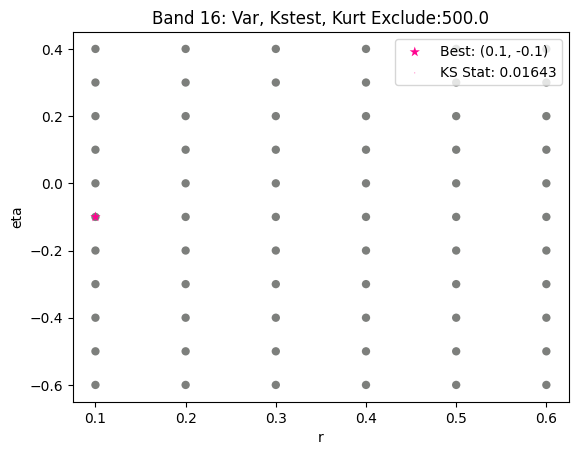

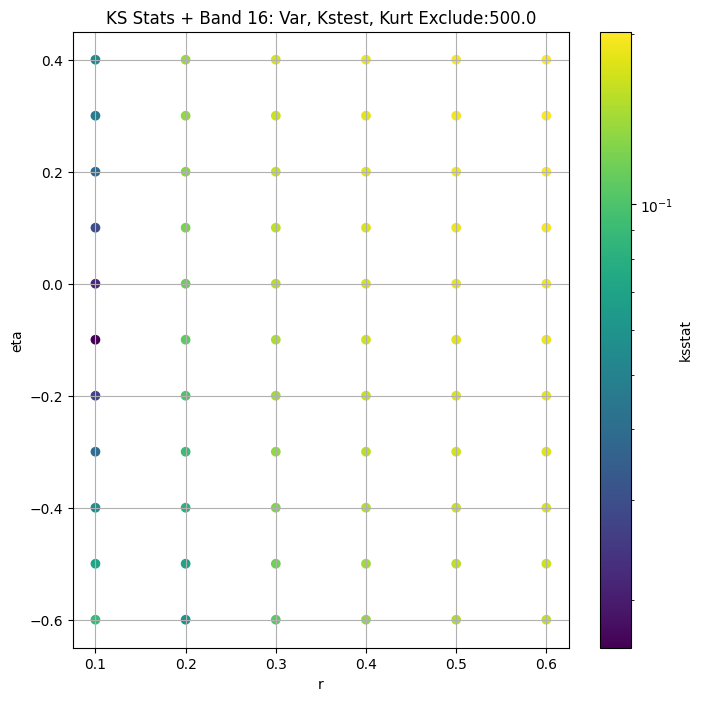

obs_var  var_lower  var_upper    obs_kurt  kurt_lower  kurt_upper  \
band                                                                       
2     0.019185   0.015339   0.024193   77.111083   32.462231  143.300153   
3     0.290274   0.250924   0.333447   28.419666   22.643105   35.219307   
5     2.376846   2.199406   2.559823    6.729836    5.871219    7.655770   
6     1.501561   1.384670   1.622058    7.474615    6.587994    8.426250   
8     0.123590   0.108467   0.141458   24.692726   14.516626   44.993672   
9     0.030323   0.026899   0.034846   22.783432   10.848627   68.245280   
11    0.017838   0.014691   0.021523   52.056832   33.944059   89.044404   
12    0.007811   0.006184   0.009895   81.076527   46.481374  165.296812   
14    0.000473   0.000361   0.000701  175.249809   47.627103  614.202212   
16    0.000118   0.000077   0.000184  299.694420  109.983114  753.488633   

      total_samples  kstest_stat_initial  initial_r  initial_eta  \
band                                                               
2           98856.0             0.002345        0.1          1.4   
3          110055.0             0.017449        0.1         -0.5   
5         1090100.0             0.010825        0.6         -1.1   
6          550640.0             0.010834        0.5         -1.1   
8         3568842.0             0.002511        0.4         -1.0   
9         5354720.0             0.005212        0.7         -1.1   
11        6785573.0             0.007333        0.1         -0.4   
12       22346151.0             0.009544        0.1         -0.4   
14       12581431.0             0.011502        0.1          0.0   
16        8227229.0             0.016434        0.1         -0.1   

      initial_scale  initial_exclude_cutoff  best_augmented_var  \
band                                                              
2      8.714470e-18                    50.0            0.014949   
3      7.771955e-13                    50.0            0.260532   
5      2.564495e+00                    75.0            2.254891   
6      1.003851e+00                    50.0            1.445545   
8      2.532721e-02                     0.0            0.123590   
9      3.753731e-02                   200.0            0.024084   
11     2.390707e-14                    25.0            0.016028   
12     7.286524e-15                   150.0            0.004885   
14     2.345080e-17                   500.0            0.000167   
16     4.560591e-18                   500.0            0.000019   

      kstest_stat_cutoff_0.05  
band                           
2                    0.004318  
3                    0.004092  
5                    0.001301  
6                    0.001830  
8                    0.000719  
9                    0.000587  
11                   0.000521  
12                   0.000287  
14                   0.000383  
16                   0.000473

In [13]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        if len(sample) == 0:
            continue
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]
            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j+1]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

## Optimization

In [14]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

Band 2


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
band 2, 50.0 + 100 = 150, ksstat: 0.004354401592206986, var: 0.012377077986258308


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
band 2, 50.0 + 75 = 125, ksstat: 0.003676051759145732, var: 0.012842539583933974


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
band 2, 50.0 + 50 = 100, ksstat: 0.0032746024938203055, var: 0.013397189314831316


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
band 2, 50.0 + 25 = 75, ksstat: 0.002704404245418457, var: 0.014082600979036028


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
band 2, 50.0 + 0 = 50, ksstat: 0.002290761911532657, var: 0.01494929279094437


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
band 2, 50.0 + -25 = 25, ksstat: 0.0038022470896165173, var: 0.016267528681863683


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
band 2, 50.0 + -50 = 0, ksstat: 0.006844167388364575, var: 0.0191850473674253
Number of samples: 100000, Without approximation : 98856.0


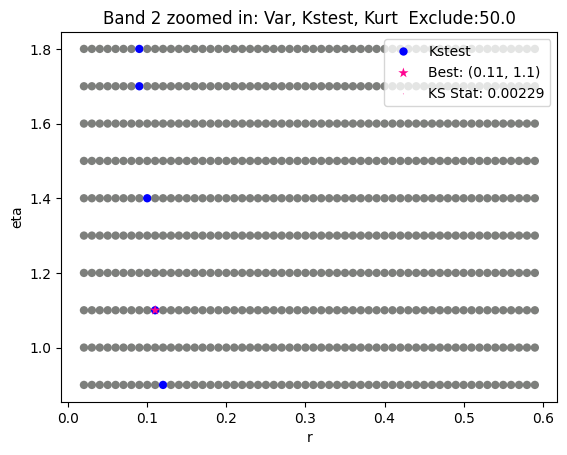

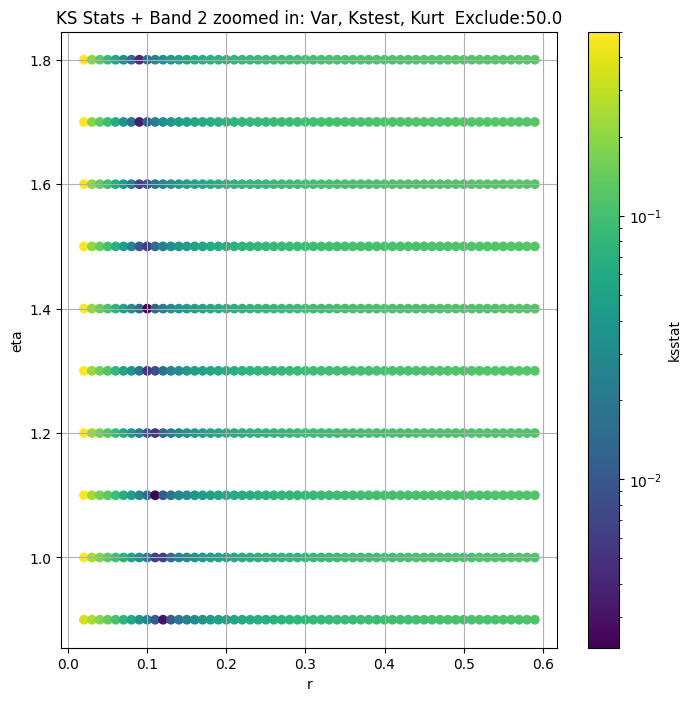

Band 3


  0%|          | 0/972 [00:00<?, ?it/s]

Finding Minimum after computing 972 CDFs
band 3, 50.0 + 100 = 150, ksstat: 0.018661030332569346, var: 0.22576904094334196


  0%|          | 0/972 [00:00<?, ?it/s]

Finding Minimum after computing 972 CDFs
band 3, 50.0 + 75 = 125, ksstat: 0.018459446270259805, var: 0.23319578692006684


  0%|          | 0/972 [00:00<?, ?it/s]

Finding Minimum after computing 972 CDFs
band 3, 50.0 + 50 = 100, ksstat: 0.018015205274050886, var: 0.2412435819659689


  0%|          | 0/972 [00:00<?, ?it/s]

Finding Minimum after computing 972 CDFs
band 3, 50.0 + 25 = 75, ksstat: 0.01776240494870092, var: 0.2501969515484272


  0%|          | 0/972 [00:00<?, ?it/s]

Finding Minimum after computing 972 CDFs
band 3, 50.0 + 0 = 50, ksstat: 0.01720167485219142, var: 0.26053247996807266


  0%|          | 0/972 [00:00<?, ?it/s]

Finding Minimum after computing 972 CDFs
band 3, 50.0 + -25 = 25, ksstat: 0.017099794377534394, var: 0.2727679772857708


  0%|          | 0/972 [00:00<?, ?it/s]

Finding Minimum after computing 972 CDFs
band 3, 50.0 + -50 = 0, ksstat: 0.016691401509867802, var: 0.2902739898785912
Number of samples: 100000, Without approximation : 110055.0


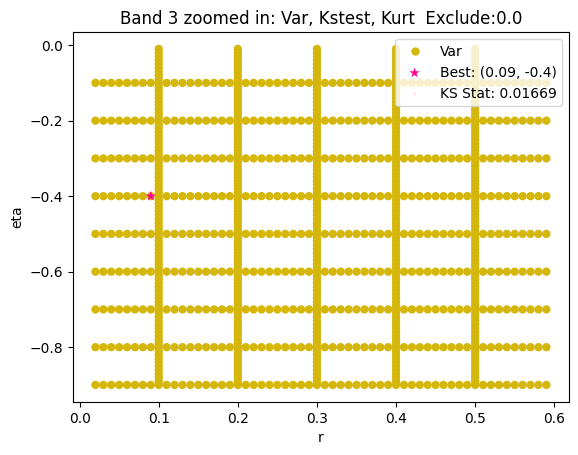

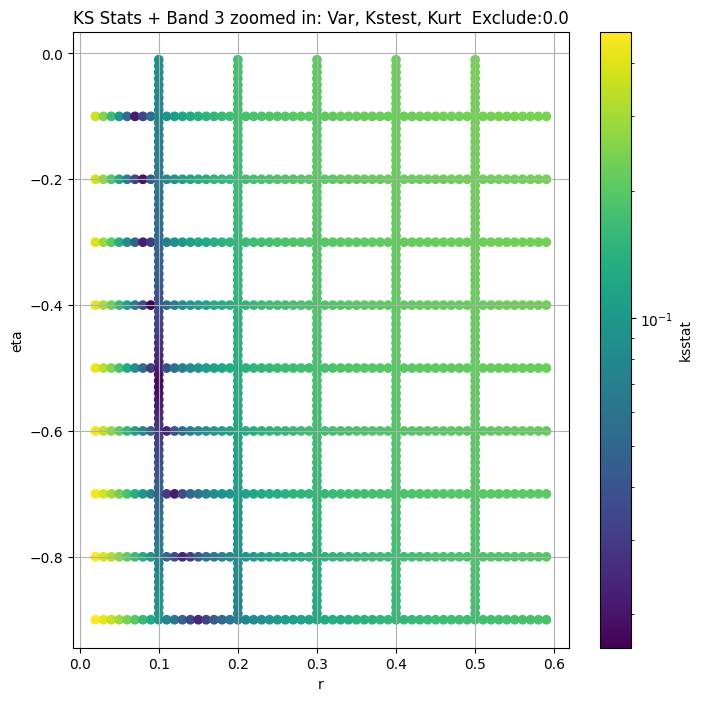

Band 5


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
band 5, 75.0 + 100 = 175, ksstat: 0.00938402218662722, var: 2.13716886102607


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
band 5, 75.0 + 75 = 150, ksstat: 0.009259690699602682, var: 2.164083619157868


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
band 5, 75.0 + 50 = 125, ksstat: 0.008760938856814393, var: 2.1924482903732376


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
band 5, 75.0 + 25 = 100, ksstat: 0.008608617077187908, var: 2.2225574328755946


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
band 5, 75.0 + 0 = 75, ksstat: 0.008595574639162828, var: 2.254890811283526


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
band 5, 75.0 + -25 = 50, ksstat: 0.008527900824061962, var: 2.2898607129401913


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
band 5, 75.0 + -50 = 25, ksstat: 0.008216678213607054, var: 2.328898151629391


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
band 5, 75.0 + -75 = 0, ksstat: 0.007988562572578961, var: 2.3768459671231406
Number of samples: 100000, Without approximation : 1090100.0


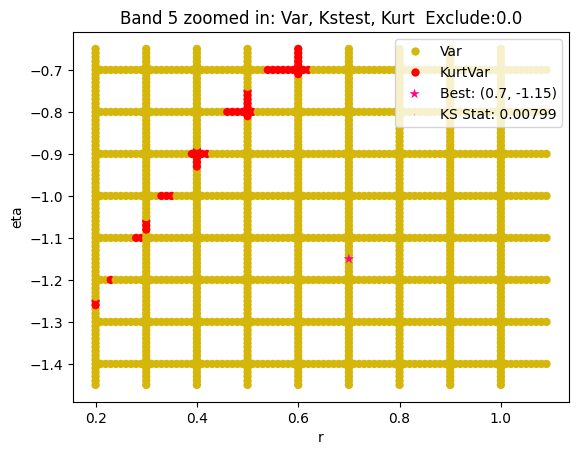

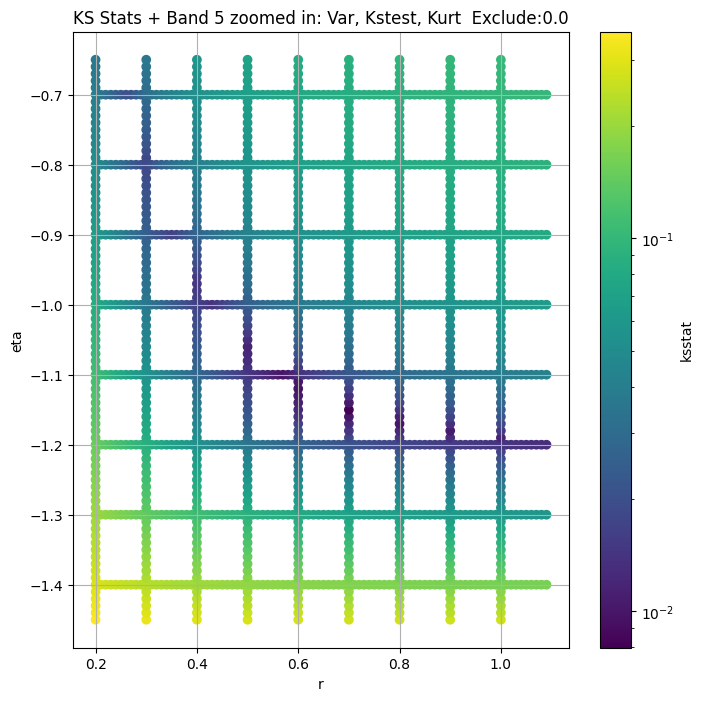

Band 6


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
band 6, 50.0 + 100 = 150, ksstat: 0.010333957215323819, var: 1.3632708927510633


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
band 6, 50.0 + 75 = 125, ksstat: 0.01047622522604607, var: 1.3818800446856683


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
band 6, 50.0 + 50 = 100, ksstat: 0.01028637172473608, var: 1.4015731168151573


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
band 6, 50.0 + 25 = 75, ksstat: 0.009714150929637809, var: 1.4227312259560239


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
band 6, 50.0 + 0 = 50, ksstat: 0.009675782811628397, var: 1.4455452824350015


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
band 6, 50.0 + -25 = 25, ksstat: 0.01054121371513482, var: 1.4708530837717586


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
band 6, 50.0 + -50 = 0, ksstat: 0.009752112881761532, var: 1.501561330909322
Number of samples: 100000, Without approximation : 550640.0


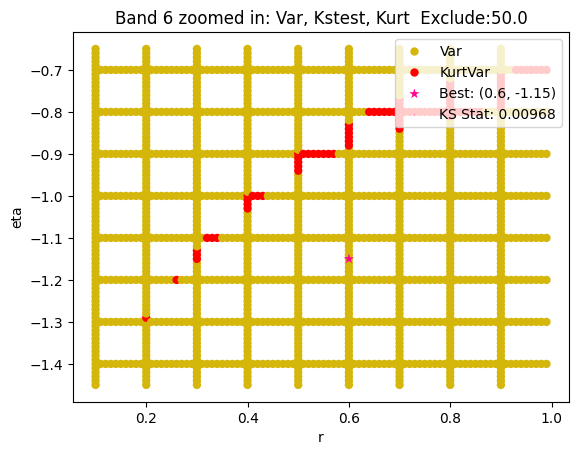

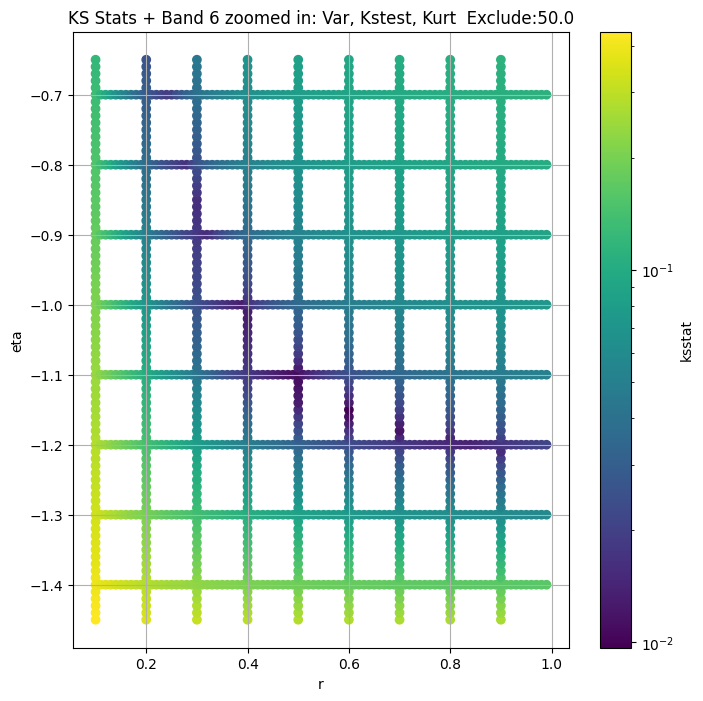

Band 8


  0%|          | 0/1480 [00:00<?, ?it/s]

Finding Minimum after computing 1480 CDFs
band 8, 0.0 + 100 = 100, ksstat: 0.002944422761023066, var: 0.10319957829681374


  0%|          | 0/1480 [00:00<?, ?it/s]

Finding Minimum after computing 1480 CDFs
band 8, 0.0 + 75 = 75, ksstat: 0.0034106570441895245, var: 0.1063232424325467


  0%|          | 0/1480 [00:00<?, ?it/s]

Finding Minimum after computing 1480 CDFs
band 8, 0.0 + 50 = 50, ksstat: 0.0030281108811542057, var: 0.1100352041765001


  0%|          | 0/1480 [00:00<?, ?it/s]

Finding Minimum after computing 1480 CDFs
band 8, 0.0 + 25 = 25, ksstat: 0.0018810046355167698, var: 0.11480020167258212


  0%|          | 0/1480 [00:00<?, ?it/s]

Finding Minimum after computing 1480 CDFs
band 8, 0.0 + 0 = 0, ksstat: 0.0025114112801521427, var: 0.12358964145251065
Number of samples: 100000, Without approximation : 3568842.0


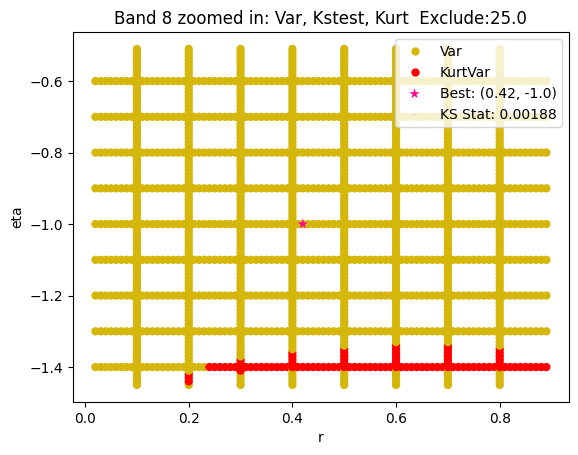

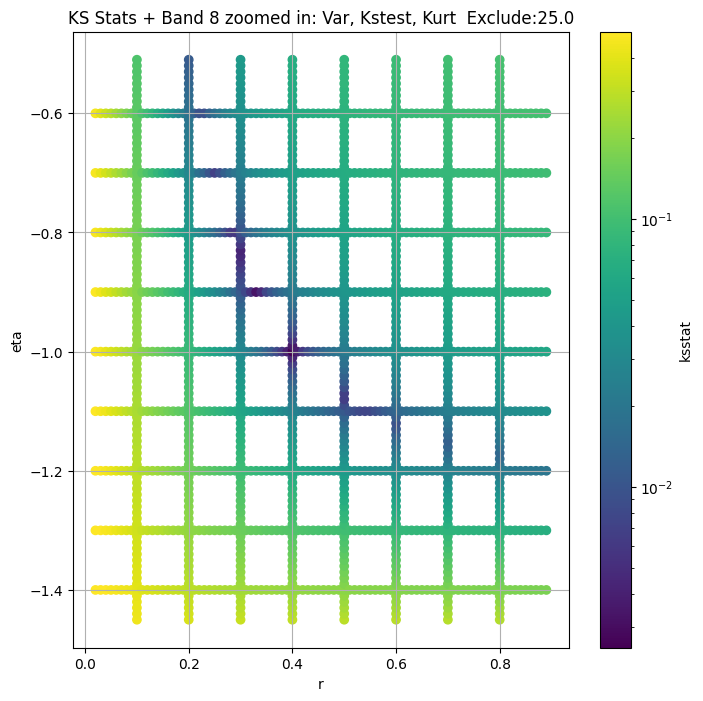

Band 9


  0%|          | 0/1570 [00:00<?, ?it/s]

Finding Minimum after computing 1570 CDFs
band 9, 200.0 + 100 = 300, ksstat: 0.006367330202467485, var: 0.0226679658661276


  0%|          | 0/1570 [00:00<?, ?it/s]

Finding Minimum after computing 1570 CDFs
band 9, 200.0 + 75 = 275, ksstat: 0.006205376415440035, var: 0.022992916326988945


  0%|          | 0/1570 [00:00<?, ?it/s]

Finding Minimum after computing 1570 CDFs
band 9, 200.0 + 50 = 250, ksstat: 0.0058968373989975315, var: 0.023335666863201234


  0%|          | 0/1570 [00:00<?, ?it/s]

Finding Minimum after computing 1570 CDFs
band 9, 200.0 + 25 = 225, ksstat: 0.005458090060665215, var: 0.02369853919977788


  0%|          | 0/1570 [00:00<?, ?it/s]

Finding Minimum after computing 1570 CDFs
band 9, 200.0 + 0 = 200, ksstat: 0.005211929687820693, var: 0.02408428325853579


  0%|          | 0/1570 [00:00<?, ?it/s]

Finding Minimum after computing 1570 CDFs
band 9, 200.0 + -25 = 175, ksstat: 0.005254504679548355, var: 0.024497809616940515


  0%|          | 0/1570 [00:00<?, ?it/s]

Finding Minimum after computing 1570 CDFs
band 9, 200.0 + -50 = 150, ksstat: 0.0050646599151313795, var: 0.024944265736752368


  0%|          | 0/1570 [00:00<?, ?it/s]

Finding Minimum after computing 1570 CDFs
band 9, 200.0 + -75 = 125, ksstat: 0.004536910849308982, var: 0.02543381287163222


  0%|          | 0/1570 [00:00<?, ?it/s]

Finding Minimum after computing 1570 CDFs
band 9, 200.0 + -100 = 100, ksstat: 0.004323752372003387, var: 0.025979673804696842
Number of samples: 100000, Without approximation : 5354720.0


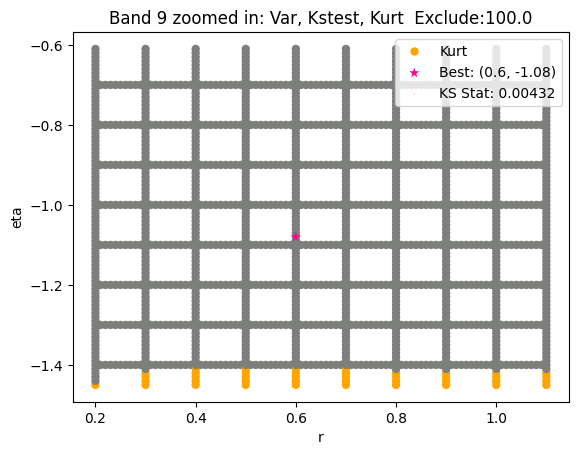

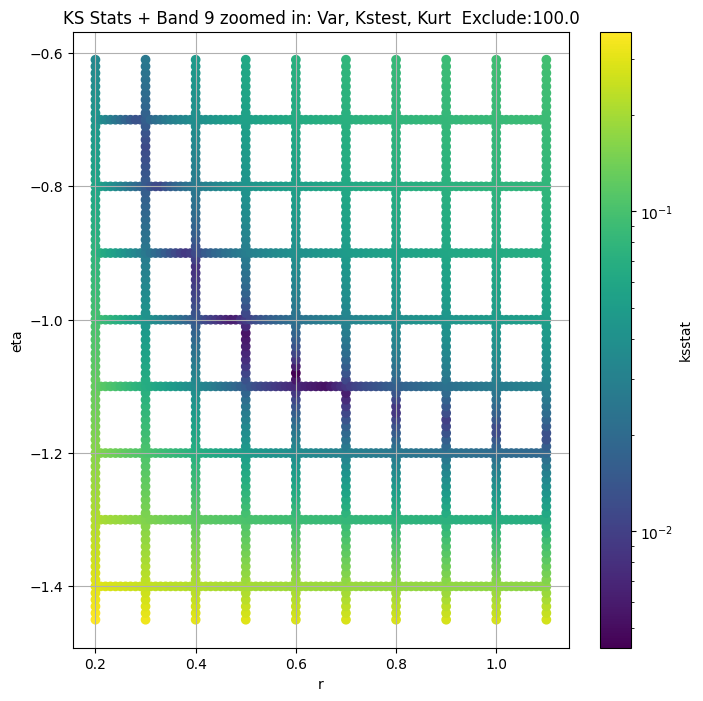

Band 11


  0%|          | 0/927 [00:00<?, ?it/s]

Finding Minimum after computing 927 CDFs
band 11, 25.0 + 100 = 125, ksstat: 0.008808403850779967, var: 0.012897270059663232


  0%|          | 0/927 [00:00<?, ?it/s]

Finding Minimum after computing 927 CDFs
band 11, 25.0 + 75 = 100, ksstat: 0.008642435613699817, var: 0.013488482389302567


  0%|          | 0/927 [00:00<?, ?it/s]

Finding Minimum after computing 927 CDFs
band 11, 25.0 + 50 = 75, ksstat: 0.008035866783969666, var: 0.014171005371837889


  0%|          | 0/927 [00:00<?, ?it/s]

Finding Minimum after computing 927 CDFs
band 11, 25.0 + 25 = 50, ksstat: 0.0069170748902167255, var: 0.014986254974617187


  0%|          | 0/927 [00:00<?, ?it/s]

Finding Minimum after computing 927 CDFs
band 11, 25.0 + 0 = 25, ksstat: 0.006665567749915106, var: 0.016028315489212953


  0%|          | 0/927 [00:00<?, ?it/s]

Finding Minimum after computing 927 CDFs
band 11, 25.0 + -25 = 0, ksstat: 0.006649064162584706, var: 0.017838169067403986
Number of samples: 100000, Without approximation : 6785573.0


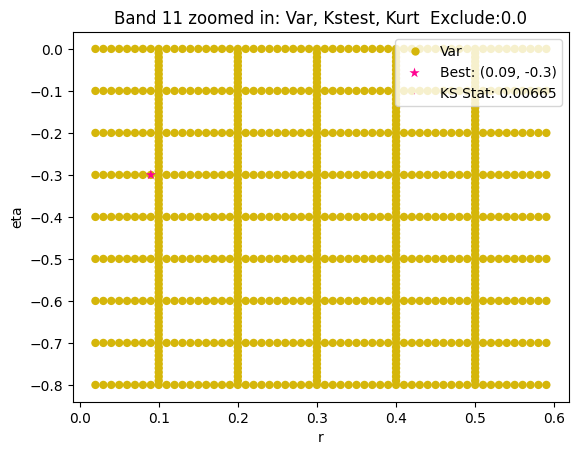

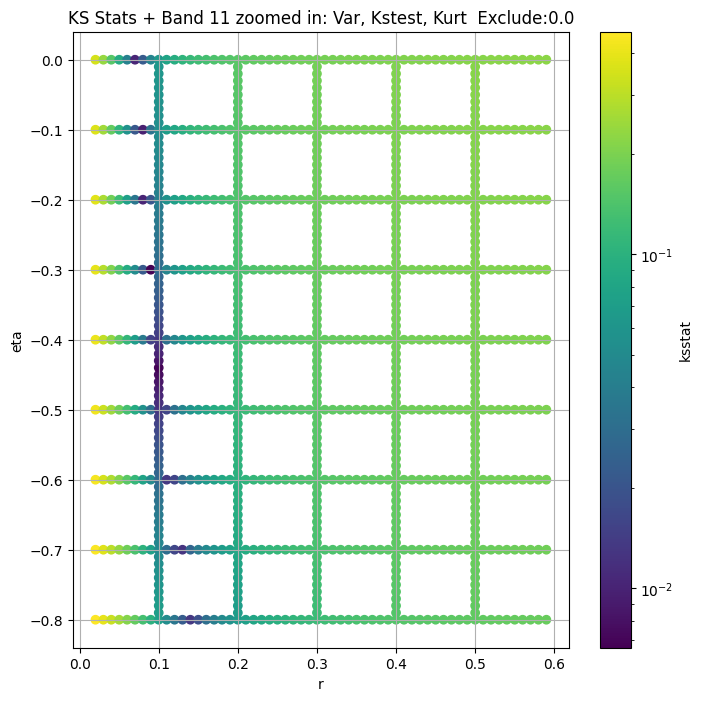

Band 12


  0%|          | 0/927 [00:00<?, ?it/s]

Finding Minimum after computing 927 CDFs
band 12, 150.0 + 100 = 250, ksstat: 0.00881113007690201, var: 0.004090743252842689


  0%|          | 0/927 [00:00<?, ?it/s]

Finding Minimum after computing 927 CDFs
band 12, 150.0 + 75 = 225, ksstat: 0.008442599098476396, var: 0.004262052773209693


  0%|          | 0/927 [00:00<?, ?it/s]

Finding Minimum after computing 927 CDFs
band 12, 150.0 + 50 = 200, ksstat: 0.00880015168239795, var: 0.004449448159624415


  0%|          | 0/927 [00:00<?, ?it/s]

Finding Minimum after computing 927 CDFs
band 12, 150.0 + 25 = 175, ksstat: 0.009396858061929025, var: 0.0046558179150785394


  0%|          | 0/927 [00:00<?, ?it/s]

Finding Minimum after computing 927 CDFs
band 12, 150.0 + 0 = 150, ksstat: 0.009264526511526872, var: 0.00488519591077759


  0%|          | 0/927 [00:00<?, ?it/s]

Finding Minimum after computing 927 CDFs
band 12, 150.0 + -25 = 125, ksstat: 0.007992444849868996, var: 0.005143212783845933


  0%|          | 0/927 [00:00<?, ?it/s]

Finding Minimum after computing 927 CDFs
band 12, 150.0 + -50 = 100, ksstat: 0.0098552352481594, var: 0.005438532334244256


  0%|          | 0/927 [00:00<?, ?it/s]

Finding Minimum after computing 927 CDFs
band 12, 150.0 + -75 = 75, ksstat: 0.011879606661421405, var: 0.005785335752008048


  0%|          | 0/927 [00:00<?, ?it/s]

Finding Minimum after computing 927 CDFs
band 12, 150.0 + -100 = 50, ksstat: 0.012260818625802083, var: 0.006207255743044515
Number of samples: 100000, Without approximation : 22346151.0


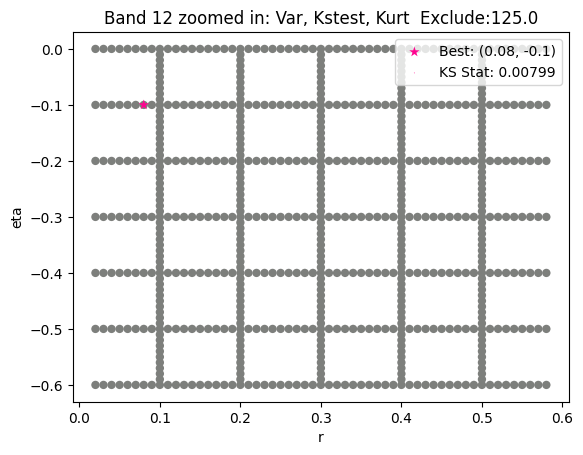

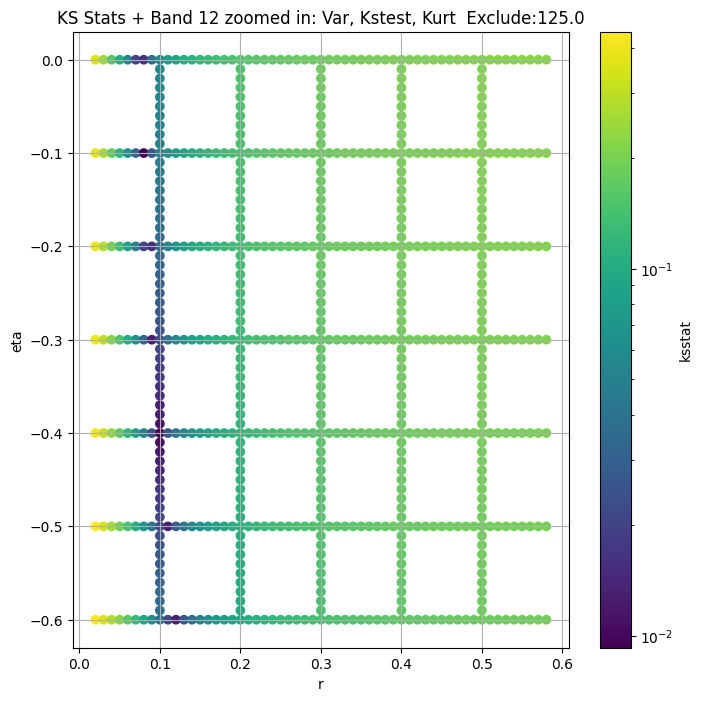

Band 14


  0%|          | 0/747 [00:00<?, ?it/s]

Finding Minimum after computing 747 CDFs
band 14, 500.0 + 100 = 600, ksstat: 0.011061752360374285, var: 0.00014867529903555665


  0%|          | 0/747 [00:00<?, ?it/s]

Finding Minimum after computing 747 CDFs
band 14, 500.0 + 75 = 575, ksstat: 0.011043077270712796, var: 0.00015289768933421868


  0%|          | 0/747 [00:00<?, ?it/s]

Finding Minimum after computing 747 CDFs
band 14, 500.0 + 50 = 550, ksstat: 0.010971728023389448, var: 0.00015732997524003288


  0%|          | 0/747 [00:00<?, ?it/s]

Finding Minimum after computing 747 CDFs
band 14, 500.0 + 25 = 525, ksstat: 0.01059757363793165, var: 0.00016198978885188214


  0%|          | 0/747 [00:00<?, ?it/s]

Finding Minimum after computing 747 CDFs
band 14, 500.0 + 0 = 500, ksstat: 0.01078094476148638, var: 0.00016689944376377863


  0%|          | 0/747 [00:00<?, ?it/s]

Finding Minimum after computing 747 CDFs
band 14, 500.0 + -25 = 475, ksstat: 0.010328432680063449, var: 0.0001720773482727382


  0%|          | 0/747 [00:00<?, ?it/s]

Finding Minimum after computing 747 CDFs
band 14, 500.0 + -50 = 450, ksstat: 0.010003211769240072, var: 0.00017754990151259482


  0%|          | 0/747 [00:00<?, ?it/s]

Finding Minimum after computing 747 CDFs
band 14, 500.0 + -75 = 425, ksstat: 0.00992138414091018, var: 0.00018334427636407857


  0%|          | 0/747 [00:00<?, ?it/s]

Finding Minimum after computing 747 CDFs
band 14, 500.0 + -100 = 400, ksstat: 0.01108162969791121, var: 0.00018949091381898636
Number of samples: 100000, Without approximation : 12581431.0


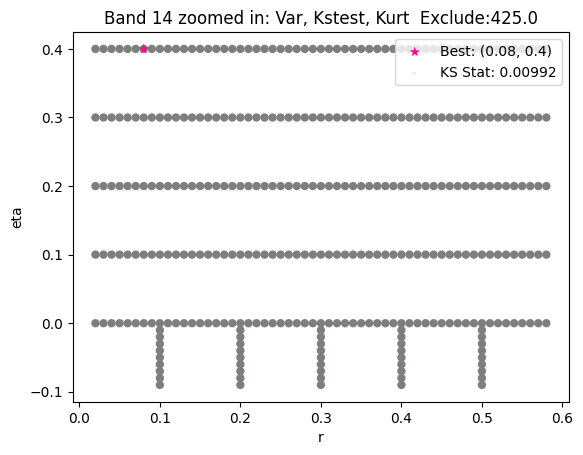

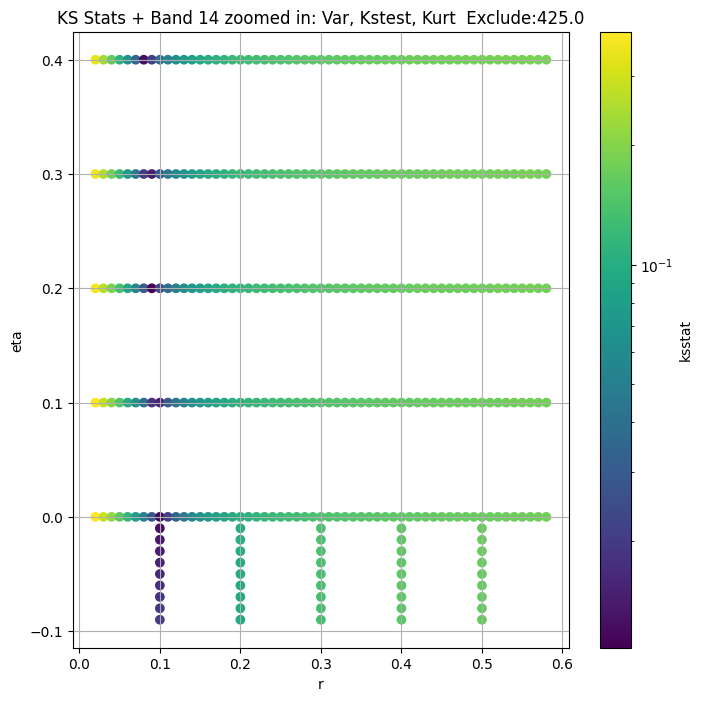

Band 16


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
band 16, 500.0 + 100 = 600, ksstat: 0.01266242991919847, var: 1.580463632875582e-05


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
band 16, 500.0 + 75 = 575, ksstat: 0.013401874174178596, var: 1.6502745095723376e-05


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
band 16, 500.0 + 50 = 550, ksstat: 0.01371293268937479, var: 1.7253791567834014e-05


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
band 16, 500.0 + 25 = 525, ksstat: 0.014480427761839554, var: 1.806251083648425e-05


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
band 16, 500.0 + 0 = 500, ksstat: 0.014259712244347411, var: 1.8933689448342377e-05


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
band 16, 500.0 + -25 = 475, ksstat: 0.014432566148551929, var: 1.9876001154010112e-05


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
band 16, 500.0 + -50 = 450, ksstat: 0.0165113002979983, var: 2.0898657944782893e-05


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
band 16, 500.0 + -75 = 425, ksstat: 0.01686463750140843, var: 2.2010425058272665e-05


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
band 16, 500.0 + -100 = 400, ksstat: 0.016225414380614644, var: 2.3222431973189416e-05
Number of samples: 100000, Without approximation : 8227229.0


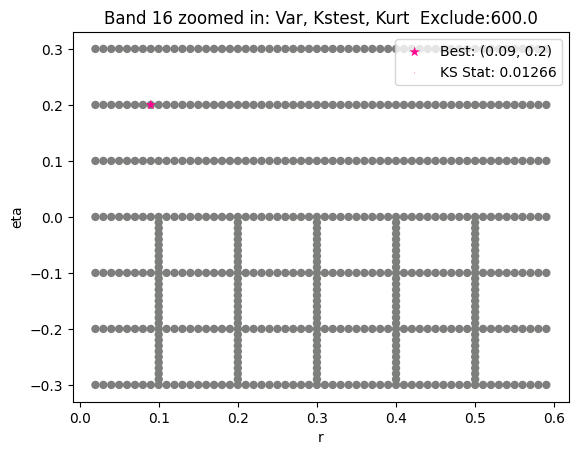

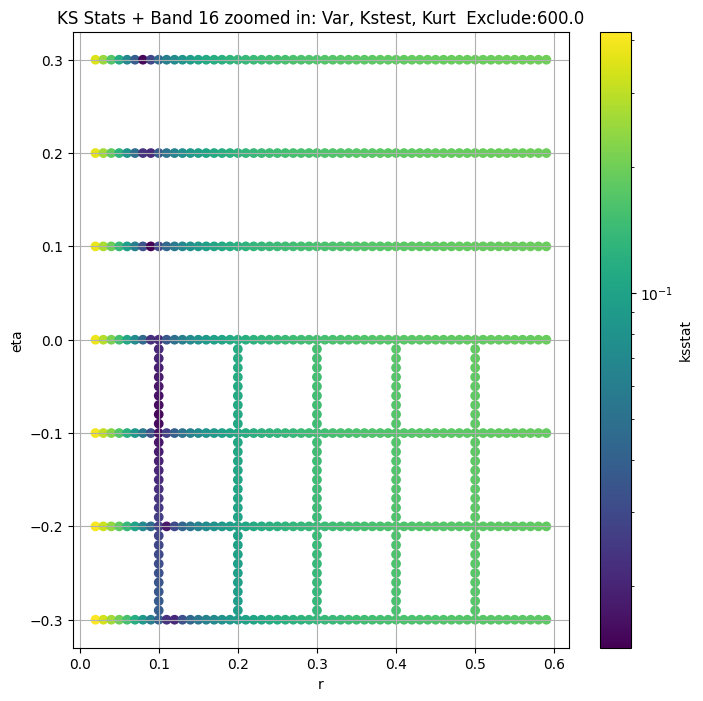

obs_var  var_lower  var_upper    obs_kurt  kurt_lower  kurt_upper  \
band                                                                       
2     0.019185   0.015339   0.024193   77.111083   32.462231  143.300153   
3     0.290274   0.250924   0.333447   28.419666   22.643105   35.219307   
5     2.376846   2.199406   2.559823    6.729836    5.871219    7.655770   
6     1.501561   1.384670   1.622058    7.474615    6.587994    8.426250   
8     0.123590   0.108467   0.141458   24.692726   14.516626   44.993672   
9     0.030323   0.026899   0.034846   22.783432   10.848627   68.245280   
11    0.017838   0.014691   0.021523   52.056832   33.944059   89.044404   
12    0.007811   0.006184   0.009895   81.076527   46.481374  165.296812   
14    0.000473   0.000361   0.000701  175.249809   47.627103  614.202212   
16    0.000118   0.000077   0.000184  299.694420  109.983114  753.488633   

      total_samples  kstest_stat_initial  initial_r  initial_eta  \
band                                                               
2           98856.0             0.002345        0.1          1.4   
3          110055.0             0.017449        0.1         -0.5   
5         1090100.0             0.010825        0.6         -1.1   
6          550640.0             0.010834        0.5         -1.1   
8         3568842.0             0.002511        0.4         -1.0   
9         5354720.0             0.005212        0.7         -1.1   
11        6785573.0             0.007333        0.1         -0.4   
12       22346151.0             0.009544        0.1         -0.4   
14       12581431.0             0.011502        0.1          0.0   
16        8227229.0             0.016434        0.1         -0.1   

      initial_scale  initial_exclude_cutoff  best_augmented_var  \
band                                                              
2      8.714470e-18                    50.0            0.014949   
3      7.771955e-13                    50.0            0.290274   
5      2.564495e+00                    75.0            2.376846   
6      1.003851e+00                    50.0            1.445545   
8      2.532721e-02                     0.0            0.114800   
9      3.753731e-02                   200.0            0.025980   
11     2.390707e-14                    25.0            0.017838   
12     7.286524e-15                   150.0            0.005143   
14     2.345080e-17                   500.0            0.000183   
16     4.560591e-18                   500.0            0.000016   

      kstest_stat_cutoff_0.05  kstest_stat_best  best_r  best_eta  \
band                                                                
2                    0.004318          0.002291    0.11      1.10   
3                    0.004092          0.016691    0.09     -0.40   
5                    0.001301          0.007989    0.70     -1.15   
6                    0.001830          0.009676    0.60     -1.15   
8                    0.000719          0.001881    0.42     -1.00   
9                    0.000587          0.004324    0.60     -1.08   
11                   0.000521          0.006649    0.09     -0.30   
12                   0.000287          0.007992    0.08     -0.10   
14                   0.000383          0.009921    0.08      0.40   
16                   0.000473          0.012662    0.09      0.20   

        best_scale  best_exclude_cutoff  n_pval_0.05  
band                                                  
2     1.206223e-15                 50.0       356278  
3     6.281420e-15                  0.0         6878  
5     4.334767e+00                  0.0        28741  
6     1.950408e+00                 50.0        19357  
8     2.937144e-02                 25.0       501867  
9     2.773785e-02                100.0        94125  
11    1.886204e-16                  0.0        39759  
12    4.981348e-20                125.0        27616  
14    8.538693e-23                425.0        18429  
16    8.278071e-21                600.

In [15]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(100, -101, -25)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            if len(sample) == 0:
                continue
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            eps = 0.5
            group_cdfs_df = fine_cdfs_df[(np.abs(master_df.loc[group, 'initial_r'] - fine_cdfs_df['r']) < eps) & 
                                        (np.abs(master_df.loc[group, 'initial_eta'] - fine_cdfs_df['eta']) < eps)].reset_index(drop=True)
            group_cdfs = {x[0]:x[1] for x in group_cdfs_df['(r,eta),cdf']}

            for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                
                exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                
                if exclude_cutoff == 0:
                    augmented_var = np.var(group_data_map[group])
                else:
                    augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                
                cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                
                print(f"{GROUP} {group}, {master_df.loc[group, 'initial_exclude_cutoff']} + {adjust_exclude_cutoff} = {exclude_cutoff}, ksstat: {min_stat}, var: {augmented_var}")
                best_adjust = 0

                if min_stat < master_df.loc[group, 'kstest_stat_best']:

                    inital_min_stat = min_stat
                    inital_best_param = initial_param
                    master_df.loc[group, 'kstest_stat_best'] = min_stat
                    initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                    master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                    master_df.loc[group, 'best_scale'] = initial_scale
                    master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                    master_df.loc[group, 'best_augmented_var'] = augmented_var
                    augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                    best_adjust = adjust_exclude_cutoff

                if exclude_cutoff == 0:
                    break

            cutoff_label = generate_cutoff_label(best_adjust)
            ksstats = group_cdfs_df[f"ksstat_exclude_{cutoff_label}"]
            
            print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
            
            cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
            master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

            best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

            group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
            group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

            group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

            group_dict = rEtaKsstats_dict[group]
            group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
            rEtaKsstats_dict[group] = group_dict

            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(group_cdfs_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)

rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

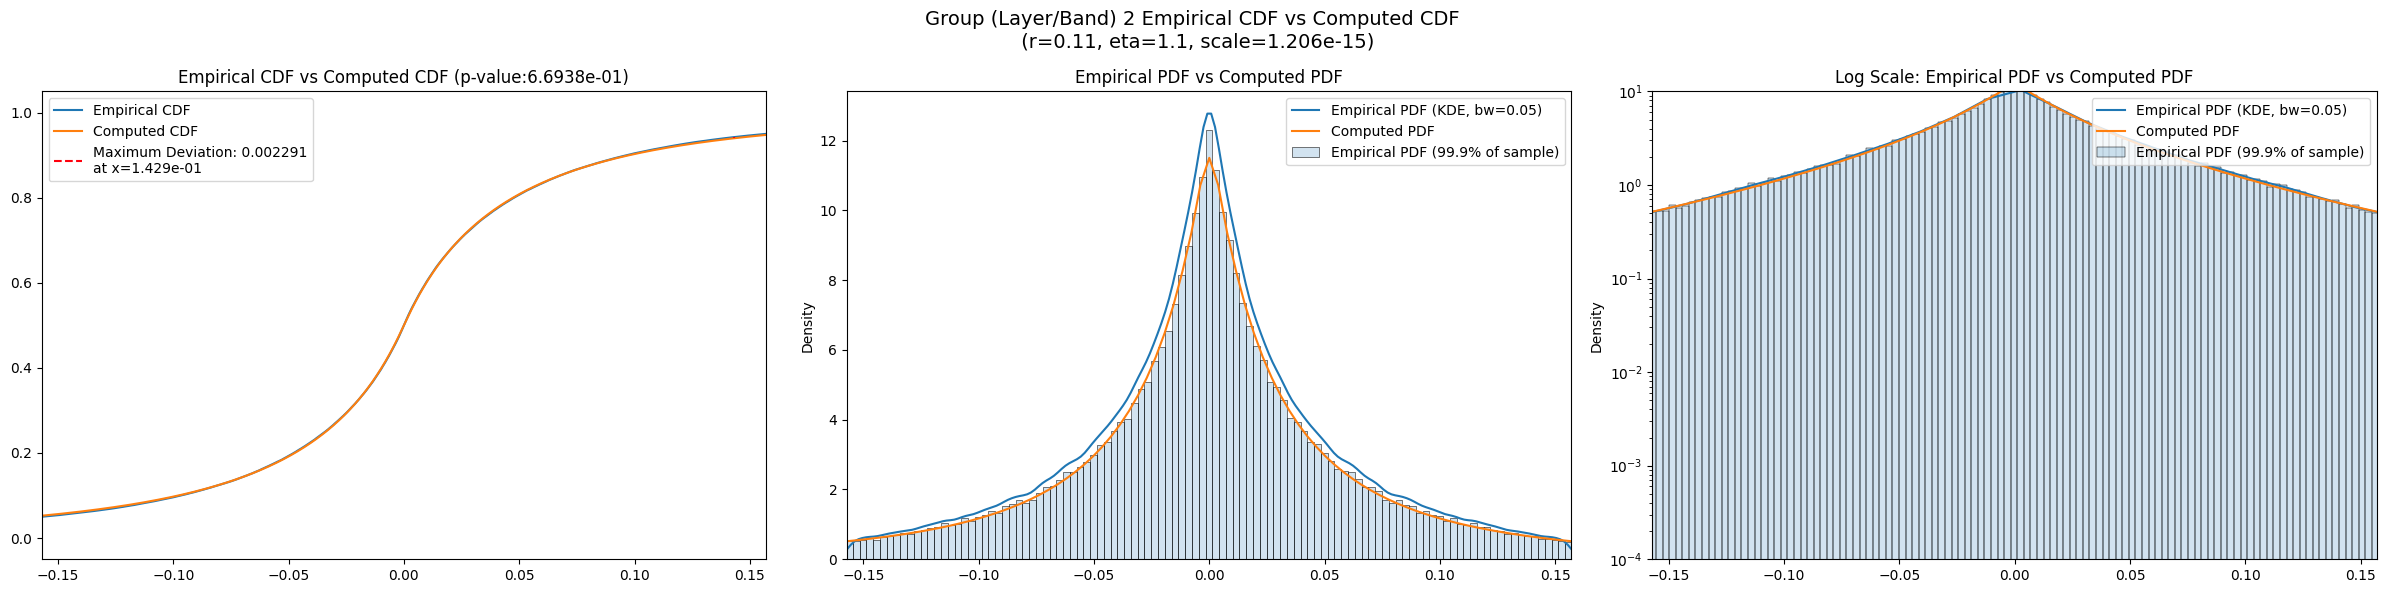

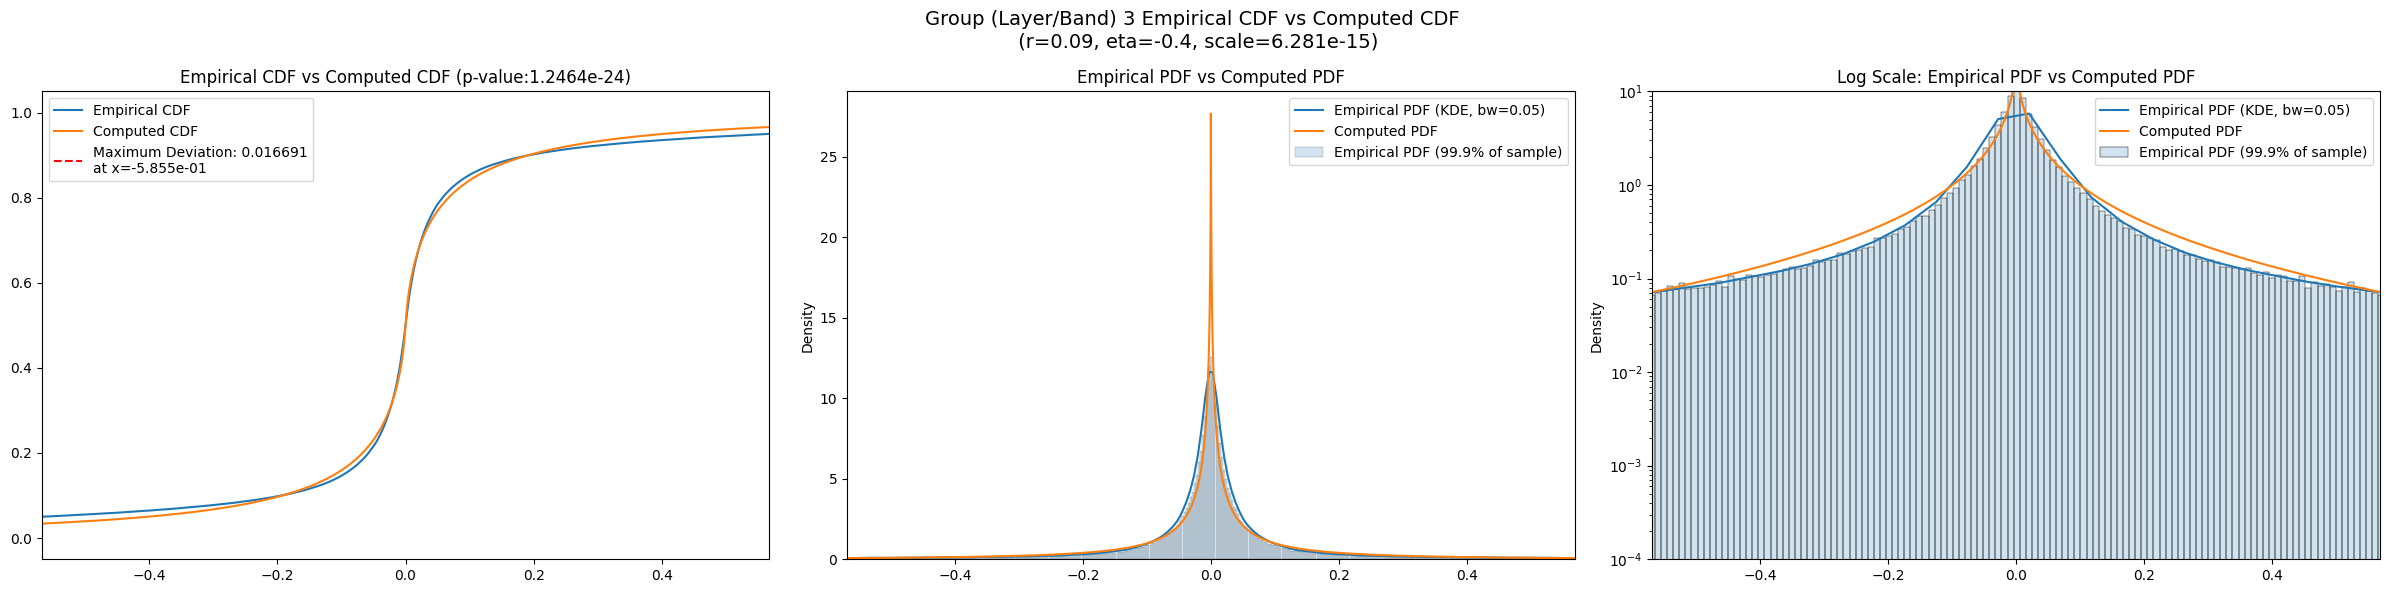

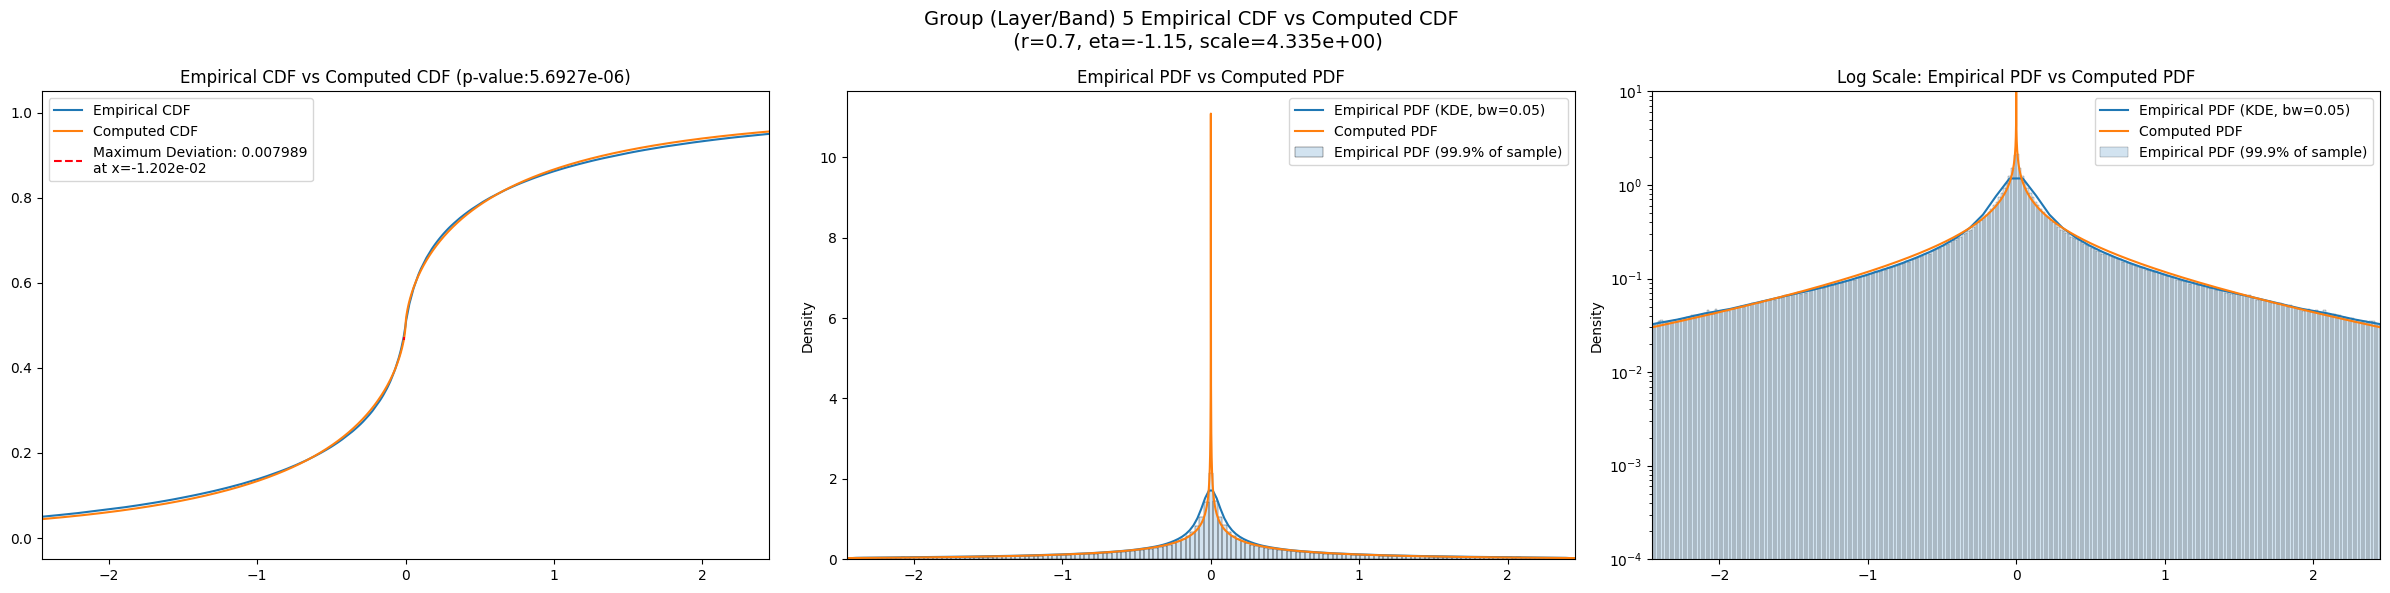

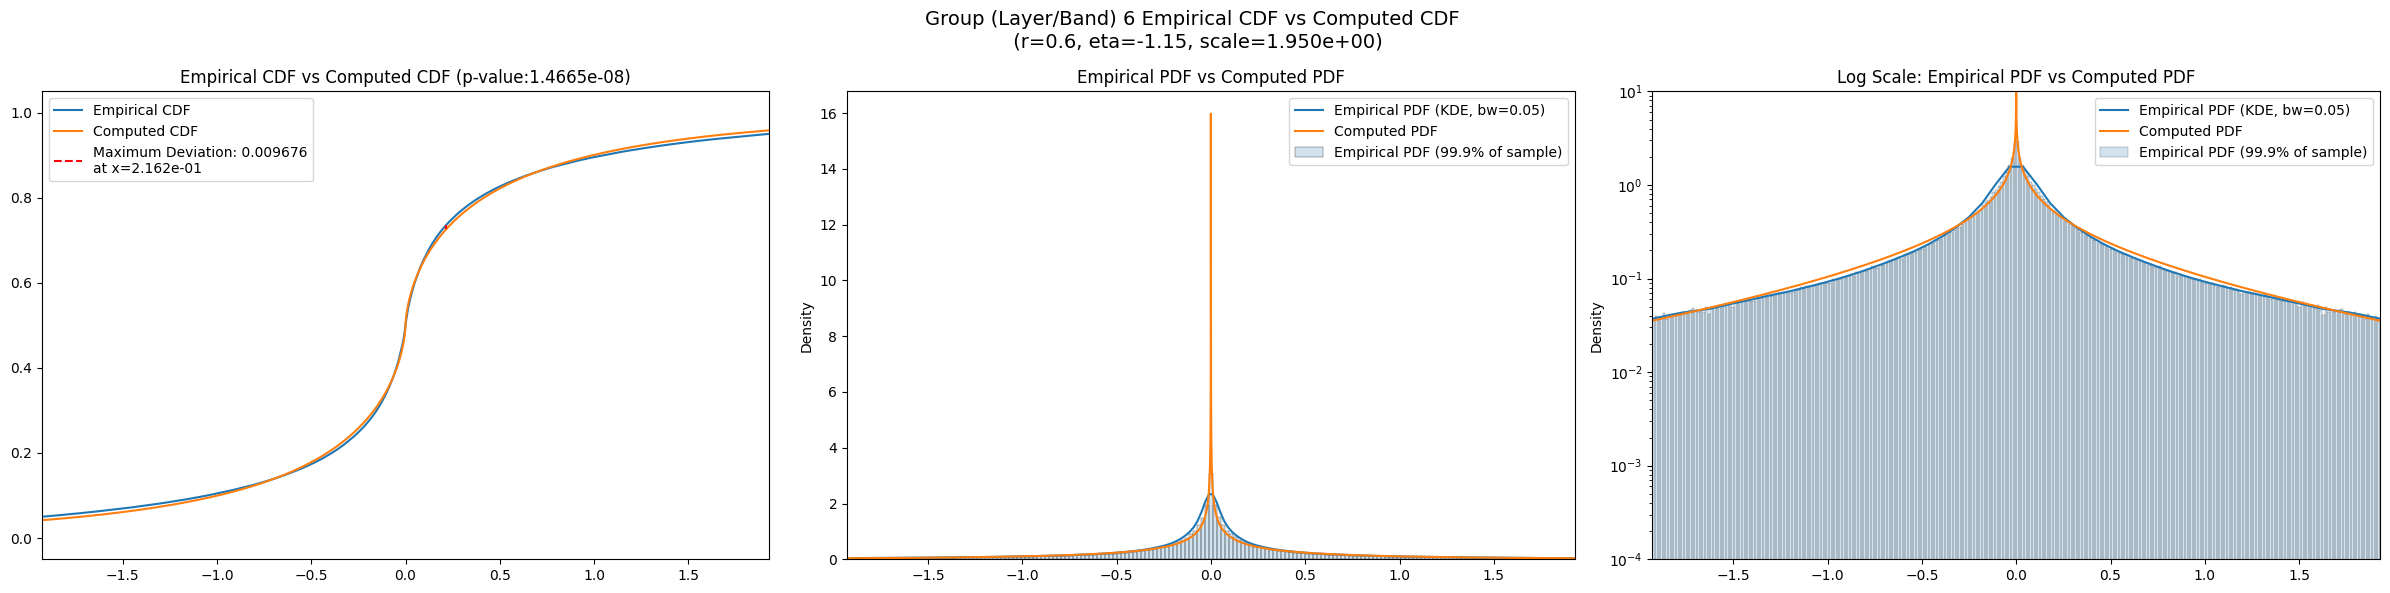

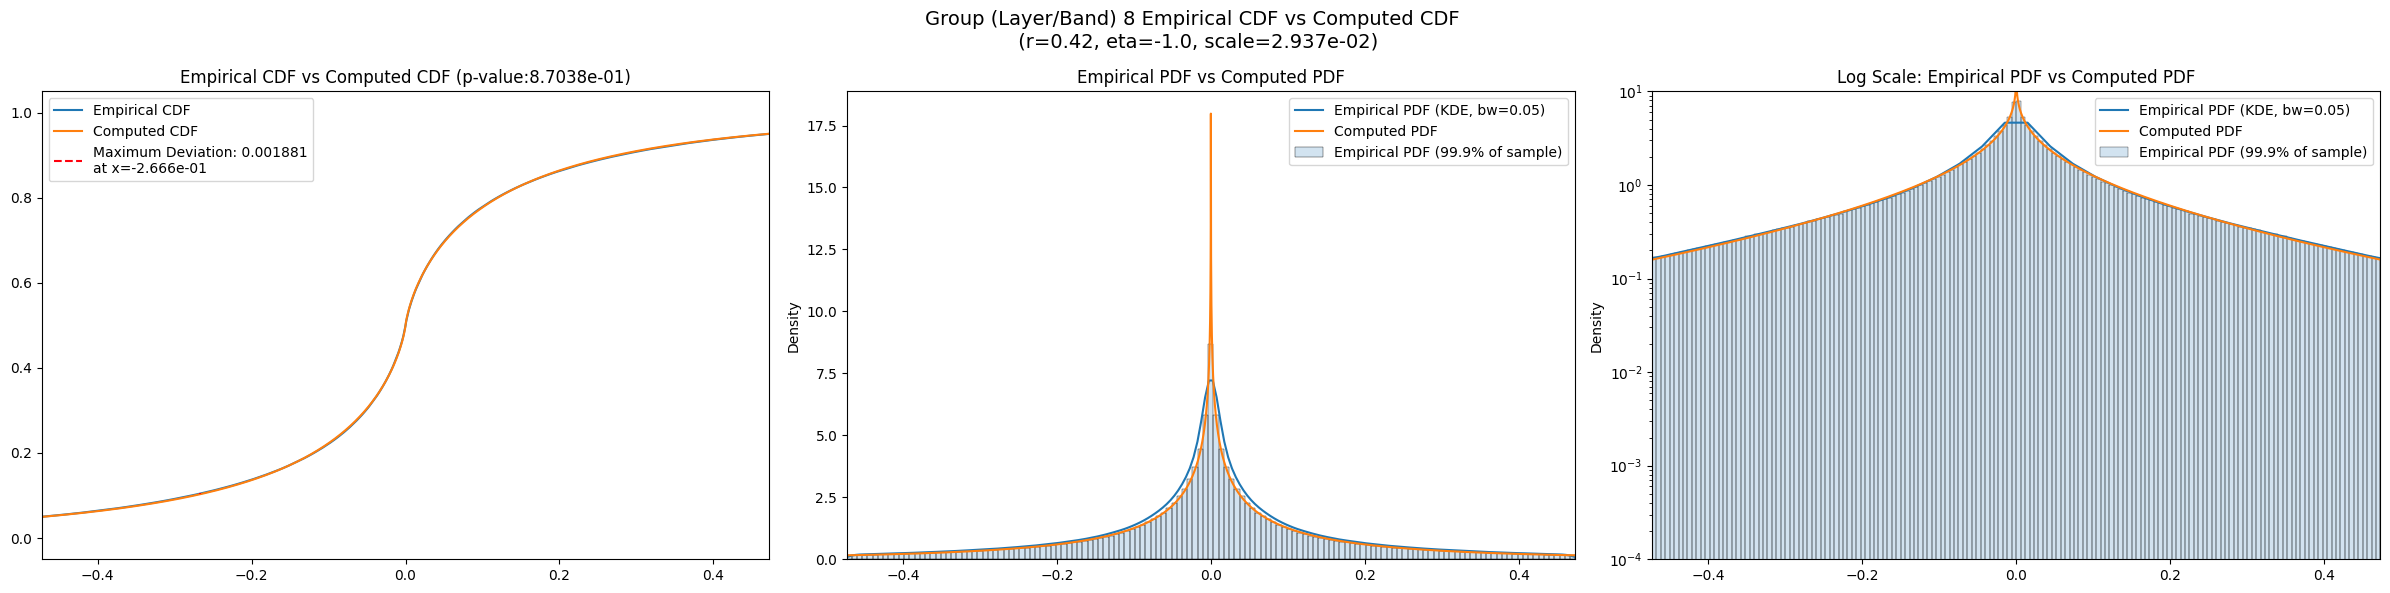

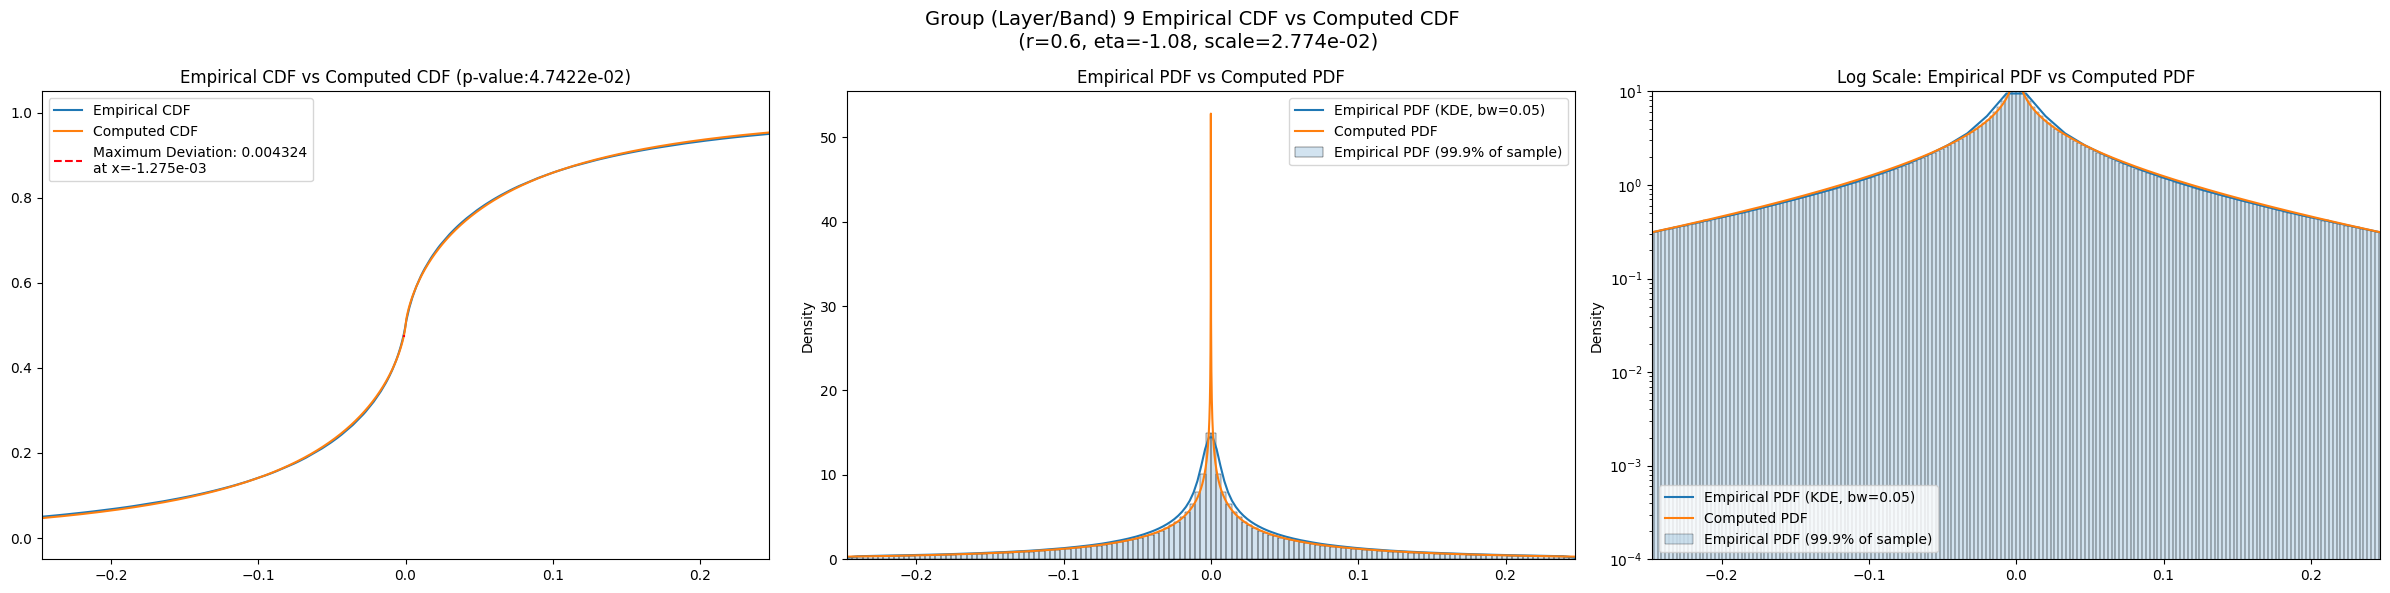

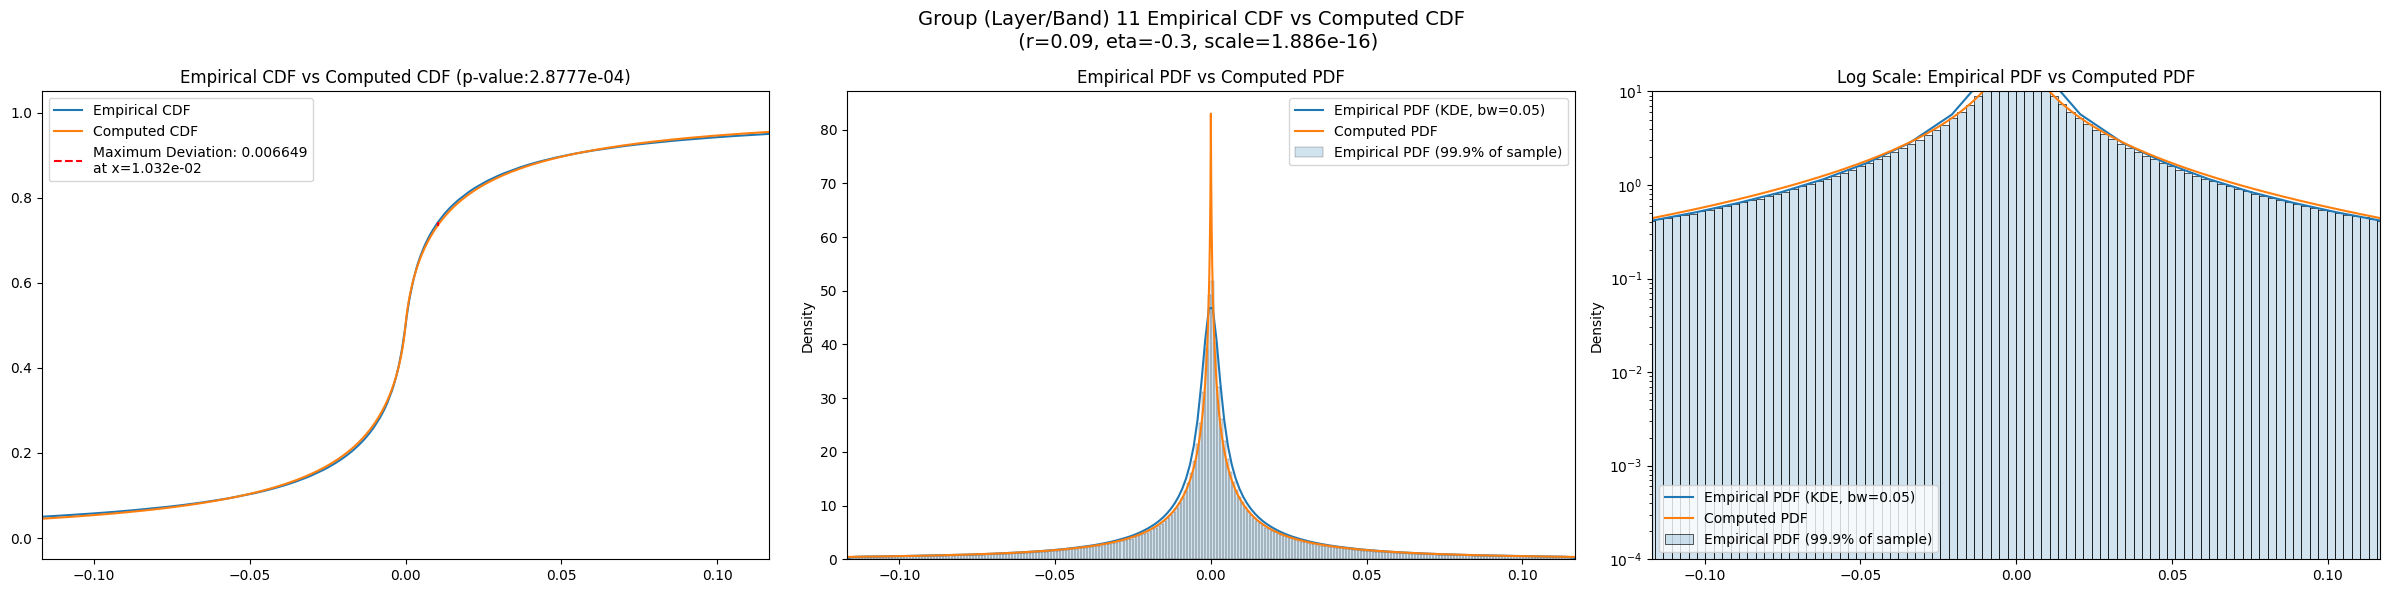

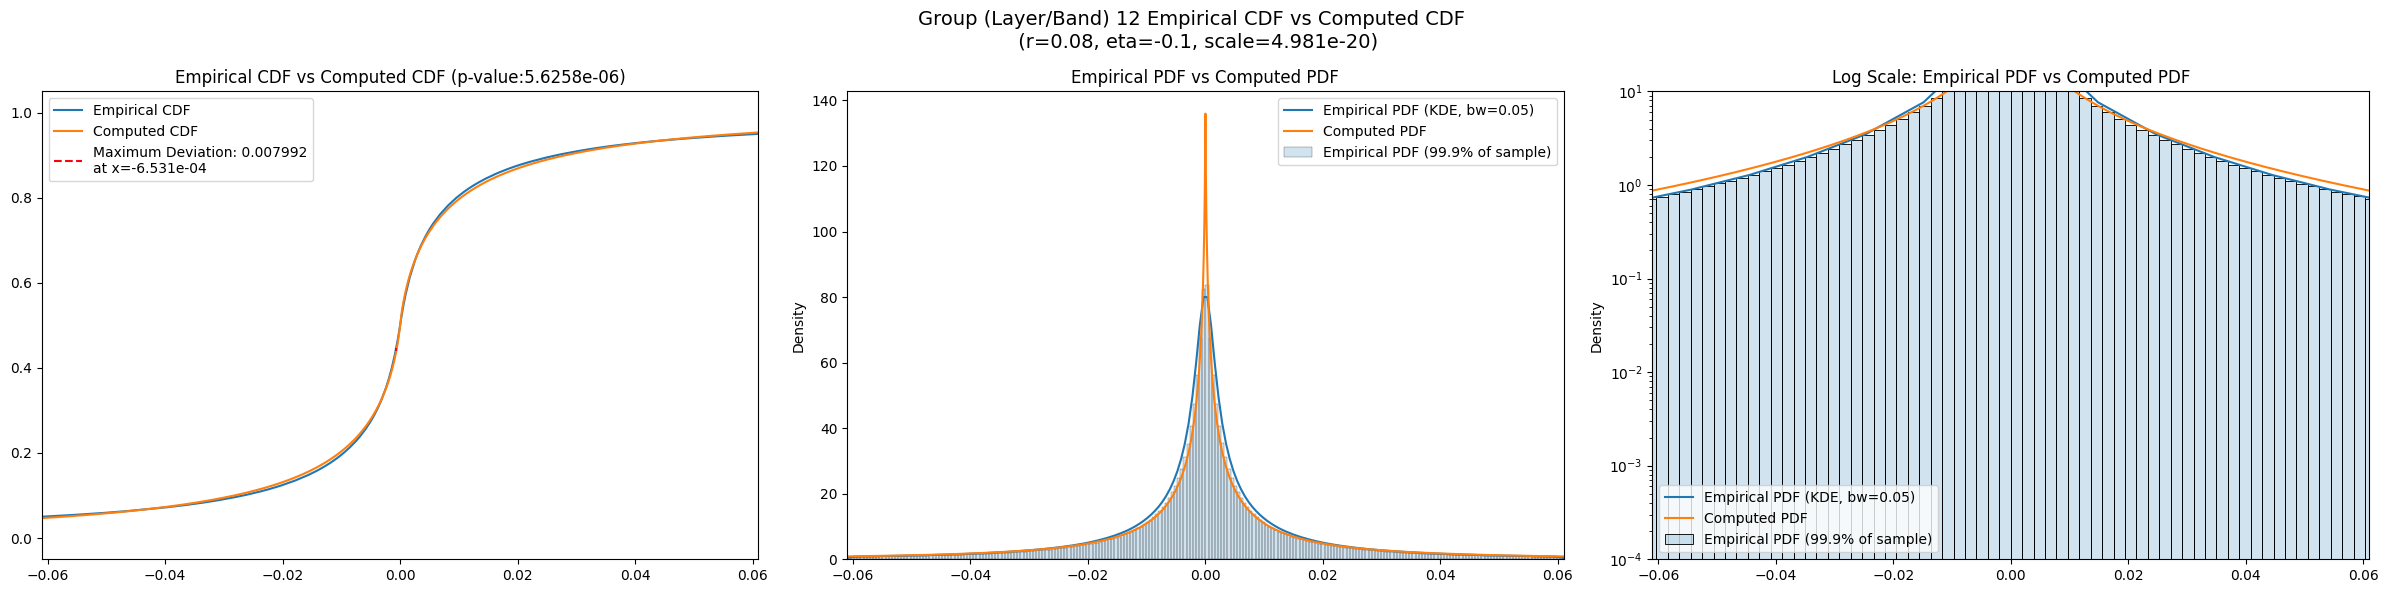

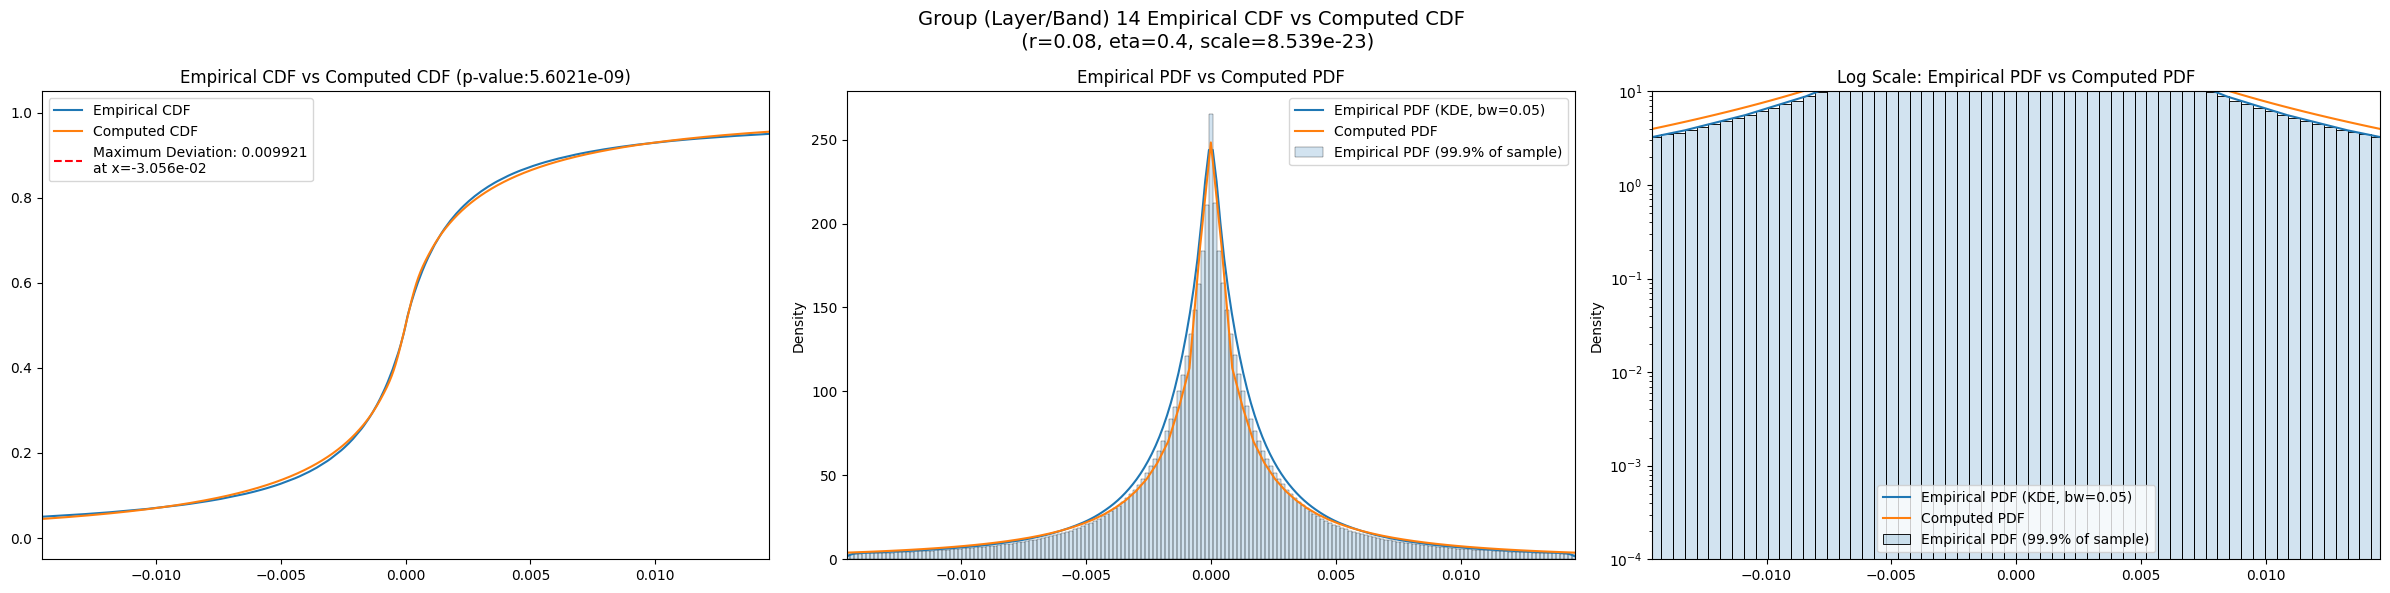

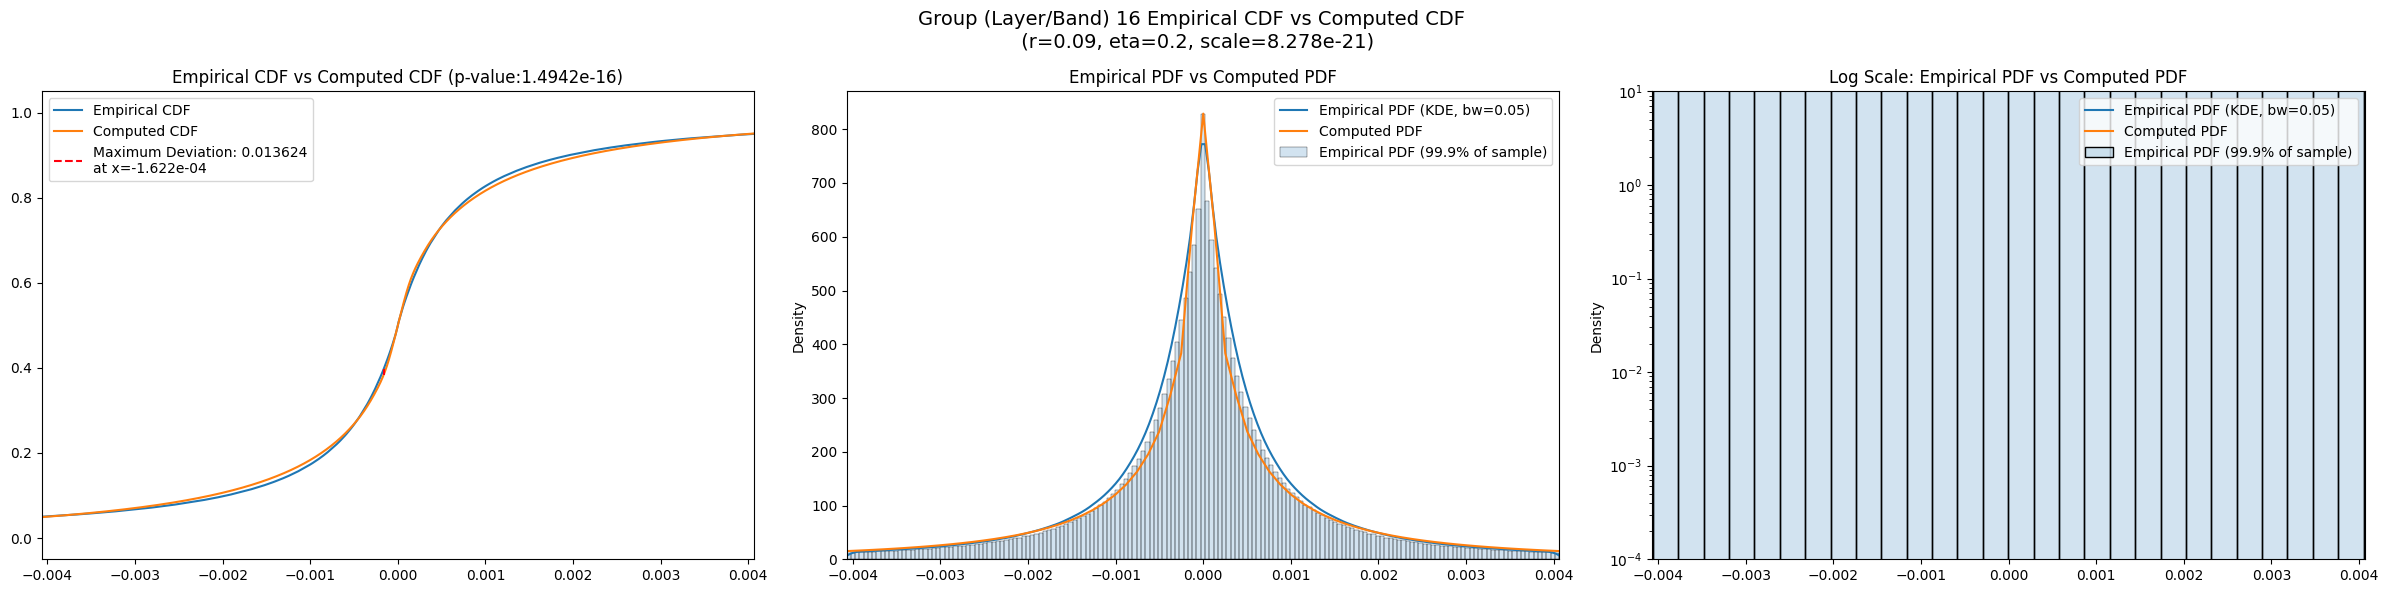

In [16]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [17]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [18]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        if len(group_data_map[group]) == 0:
            continue
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

obs_var  var_lower  var_upper    obs_kurt  kurt_lower  kurt_upper  \
band                                                                       
2     0.019185   0.015339   0.024193   77.111083   32.462231  143.300153   
3     0.290274   0.250924   0.333447   28.419666   22.643105   35.219307   
5     2.376846   2.199406   2.559823    6.729836    5.871219    7.655770   
6     1.501561   1.384670   1.622058    7.474615    6.587994    8.426250   
8     0.123590   0.108467   0.141458   24.692726   14.516626   44.993672   
9     0.030323   0.026899   0.034846   22.783432   10.848627   68.245280   
11    0.017838   0.014691   0.021523   52.056832   33.944059   89.044404   
12    0.007811   0.006184   0.009895   81.076527   46.481374  165.296812   
14    0.000473   0.000361   0.000701  175.249809   47.627103  614.202212   
16    0.000118   0.000077   0.000184  299.694420  109.983114  753.488633   

      total_samples  kstest_stat_initial  initial_r  initial_eta  ...  \
band                                                              ...   
2           98856.0             0.002345        0.1          1.4  ...   
3          110055.0             0.017449        0.1         -0.5  ...   
5         1090100.0             0.010825        0.6         -1.1  ...   
6          550640.0             0.010834        0.5         -1.1  ...   
8         3568842.0             0.002511        0.4         -1.0  ...   
9         5354720.0             0.005212        0.7         -1.1  ...   
11        6785573.0             0.007333        0.1         -0.4  ...   
12       22346151.0             0.009544        0.1         -0.4  ...   
14       12581431.0             0.011502        0.1          0.0  ...   
16        8227229.0             0.016434        0.1         -0.1  ...   

      param_gaussian  kstest_stat_gaussian  kstest_pval_gaussian  \
band                                                               
2           0.061627              0.049758         3.777790e-213   
3           0.086424              0.088380          0.000000e+00   
5           0.701650              0.079624          0.000000e+00   
6           0.505626              0.081668          0.000000e+00   
8           0.151322              0.068678          0.000000e+00   
9           0.077473              0.070009          0.000000e+00   
11          0.023884              0.085619          0.000000e+00   
12          0.013110              0.080572          0.000000e+00   
14          0.003804              0.069197          0.000000e+00   
16          0.001144              0.065940          0.000000e+00   

      param_laplace  kstest_stat_laplace  kstest_pval_laplace   param_t  \
band                                                                      
2          0.054166             0.022927         1.432070e-45  0.042905   
3          0.079187             0.066654         0.000000e+00  0.059491   
5          0.601342             0.054239         0.000000e+00  0.470954   
6          0.439374             0.056104         0.000000e+00  0.339369   
8          0.130859             0.042436         0.000000e+00  0.102807   
9          0.066604             0.044415         0.000000e+00  0.052228   
11         0.021084             0.061318         0.000000e+00  0.015979   
12         0.011668             0.056163         0.000000e+00  0.008860   
14         0.003428             0.045150         0.000000e+00  0.002620   
16         0.001028             0.041729         0.000000e+00  0.000793   

      kstest_stat_t  kstest_pval_t  kstest_pval_gengamma  
band                                                      
2          0.024159   1.480920e-50          6.764284e-01  
3          0.060672   0.000000e+00          4.594509e-27  
5          0.055938   0.000000e+00          7.473781e-61  
6          0.056012   0.000000e+00          3.314270e-45  
8          0.044235   0.000000e+00          2.150993e-11  
9          0.046313   0.000000e+00          2.234368e-87  
11         0.059010   0.000

## Results

In [19]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [20]:
master_df.filter(regex="kstest_stat.*")

kstest_stat_initial  kstest_stat_cutoff_0.05  kstest_stat_best  \
band                                                                   
2                0.002345                 0.004318          0.002291   
3                0.017449                 0.004092          0.016691   
5                0.010825                 0.001301          0.007989   
6                0.010834                 0.001830          0.009676   
8                0.002511                 0.000719          0.001881   
9                0.005212                 0.000587          0.004324   
11               0.007333                 0.000521          0.006649   
12               0.009544                 0.000287          0.007992   
14               0.011502                 0.000383          0.009921   
16               0.016434                 0.000473          0.012662   

      kstest_stat_gaussian  kstest_stat_laplace  kstest_stat_t  
band                                                            
2                 0.049758             0.022927       0.024159  
3                 0.088380             0.066654       0.060672  
5                 0.079624             0.054239       0.055938  
6                 0.081668             0.056104       0.056012  
8                 0.068678             0.042436       0.044235  
9                 0.070009             0.044415       0.046313  
11                0.085619             0.061318       0.059010  
12                0.080572             0.056163       0.053147  
14                0.069197             0.045150       0.040307  
16                0.065940             0.041729       0.036785

In [21]:
master_df.filter(regex="best.*")

best_augmented_var  kstest_stat_best  best_r  best_eta    best_scale  \
band                                                                         
2               0.014949          0.002291    0.11      1.10  1.206223e-15   
3               0.290274          0.016691    0.09     -0.40  6.281420e-15   
5               2.376846          0.007989    0.70     -1.15  4.334767e+00   
6               1.445545          0.009676    0.60     -1.15  1.950408e+00   
8               0.114800          0.001881    0.42     -1.00  2.937144e-02   
9               0.025980          0.004324    0.60     -1.08  2.773785e-02   
11              0.017838          0.006649    0.09     -0.30  1.886204e-16   
12              0.005143          0.007992    0.08     -0.10  4.981348e-20   
14              0.000183          0.009921    0.08      0.40  8.538693e-23   
16              0.000016          0.012662    0.09      0.20  8.278071e-21   

      best_exclude_cutoff  
band                       
2                    50.0  
3                     0.0  
5                     0.0  
6                    50.0  
8                    25.0  
9                   100.0  
11                    0.0  
12                  125.0  
14                  425.0  
16                  600.0